In [98]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator
from datasets import MovieLensGenreCastUserData, RatioSplit, CrossValidation
from models import BinaryMFThreshold, BinaryMFThresholdExCustomFactors

import os
import time
import logging
from scipy.sparse import csr_matrix
from cmfrec import CMF
import numpy as np, pandas as pd, pickle

from utils import binarize, show_matrix, matmul, fill_nan, binarize, to_triplet
from utils import add_log, get_metrics, dot, to_sparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
k = 50
lambda_ = 10
maxiter = 800

# Load MovieLens 100k with negative sampling

In [ ]:
# root = os.path.abspath("../../cmfrec/example")

# ratings = pickle.load(open(os.path.join(root, "ratings.p"), "rb"))
# item_sideinfo_pca = pickle.load(open(os.path.join(root, "item_sideinfo_pca.p"), "rb"))
# user_side_info = pickle.load(open(os.path.join(root, "user_side_info.p"), "rb"))
# movie_id_to_title = pickle.load(open(os.path.join(root, "movie_id_to_title.p"), "rb"))
# print(ratings.shape, user_side_info.shape, item_sideinfo_pca.shape)

(1000209, 3) (6040, 39) (3102, 51)


In [4]:
data = MovieLensGenreCastUserData(size='100k')
data.load()
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [5]:
X, Y, Z, _ = data.Xs

In [6]:
X_split = RatioSplit(X, test_size=20000)
X_split

[I] RatioSplit, sampling positives
[I]   seed         : 1706020061
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1706020061


In [7]:
X_split.negative_sample(train_size=X_split.pos_train_size, test_size=X_split.pos_test_size, type='popularity')
X_split

[I] RatioSplit, sampling negatives
[I]   all_negatives: 1486126
[I]   n_negatives  : 100000
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1706020061


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
X_train, X_test = X_split.X_train, X_split.X_test

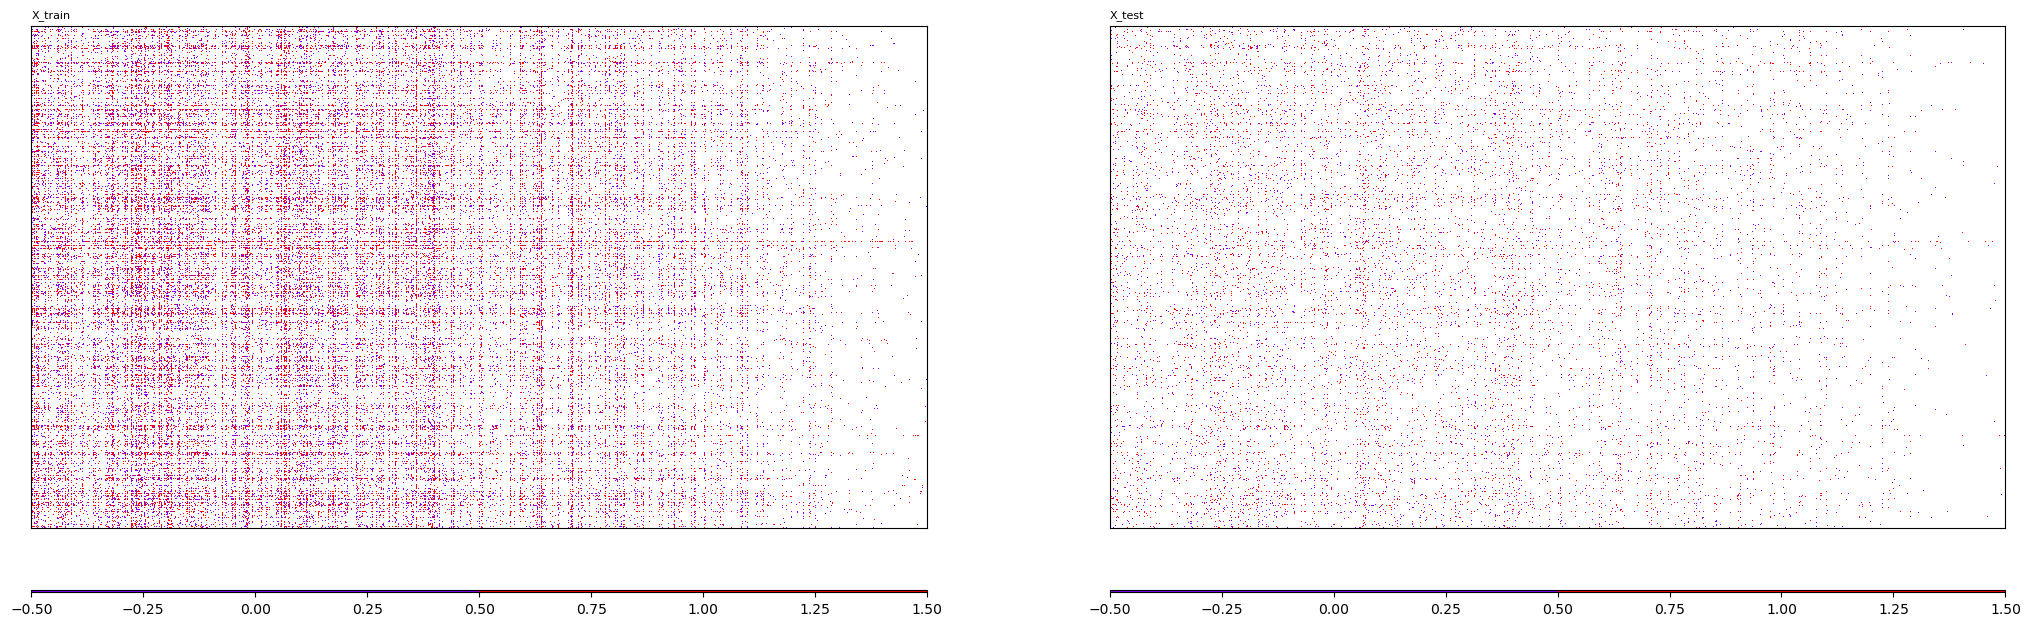

In [14]:
settings = [(X_train, [0, 0], 'X_train'), (X_test, [0, 1], 'X_test')]
show_matrix(settings=settings, colorbar=True, cmap='rainbow', discrete=True, center=True, keep_nan=True)

In [23]:
from utils import fill_nan


def show_results(A, B, a=True, b=None):

    P = A @ B.T
    
    if means is True:
        for r in range(P.shape[0]):
            P[r, :] += a[r]
        for c in range(P.shape[1]):
            P[:, c] += b[c]
        P += miu
        
    X_recover = fill_nan(P, X_train)
    X_predict = fill_nan(P, X_test)

    rng = [200, 200]
    settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
                (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
                (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
                (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
                (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
    show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-1 (no bias, nonneg)

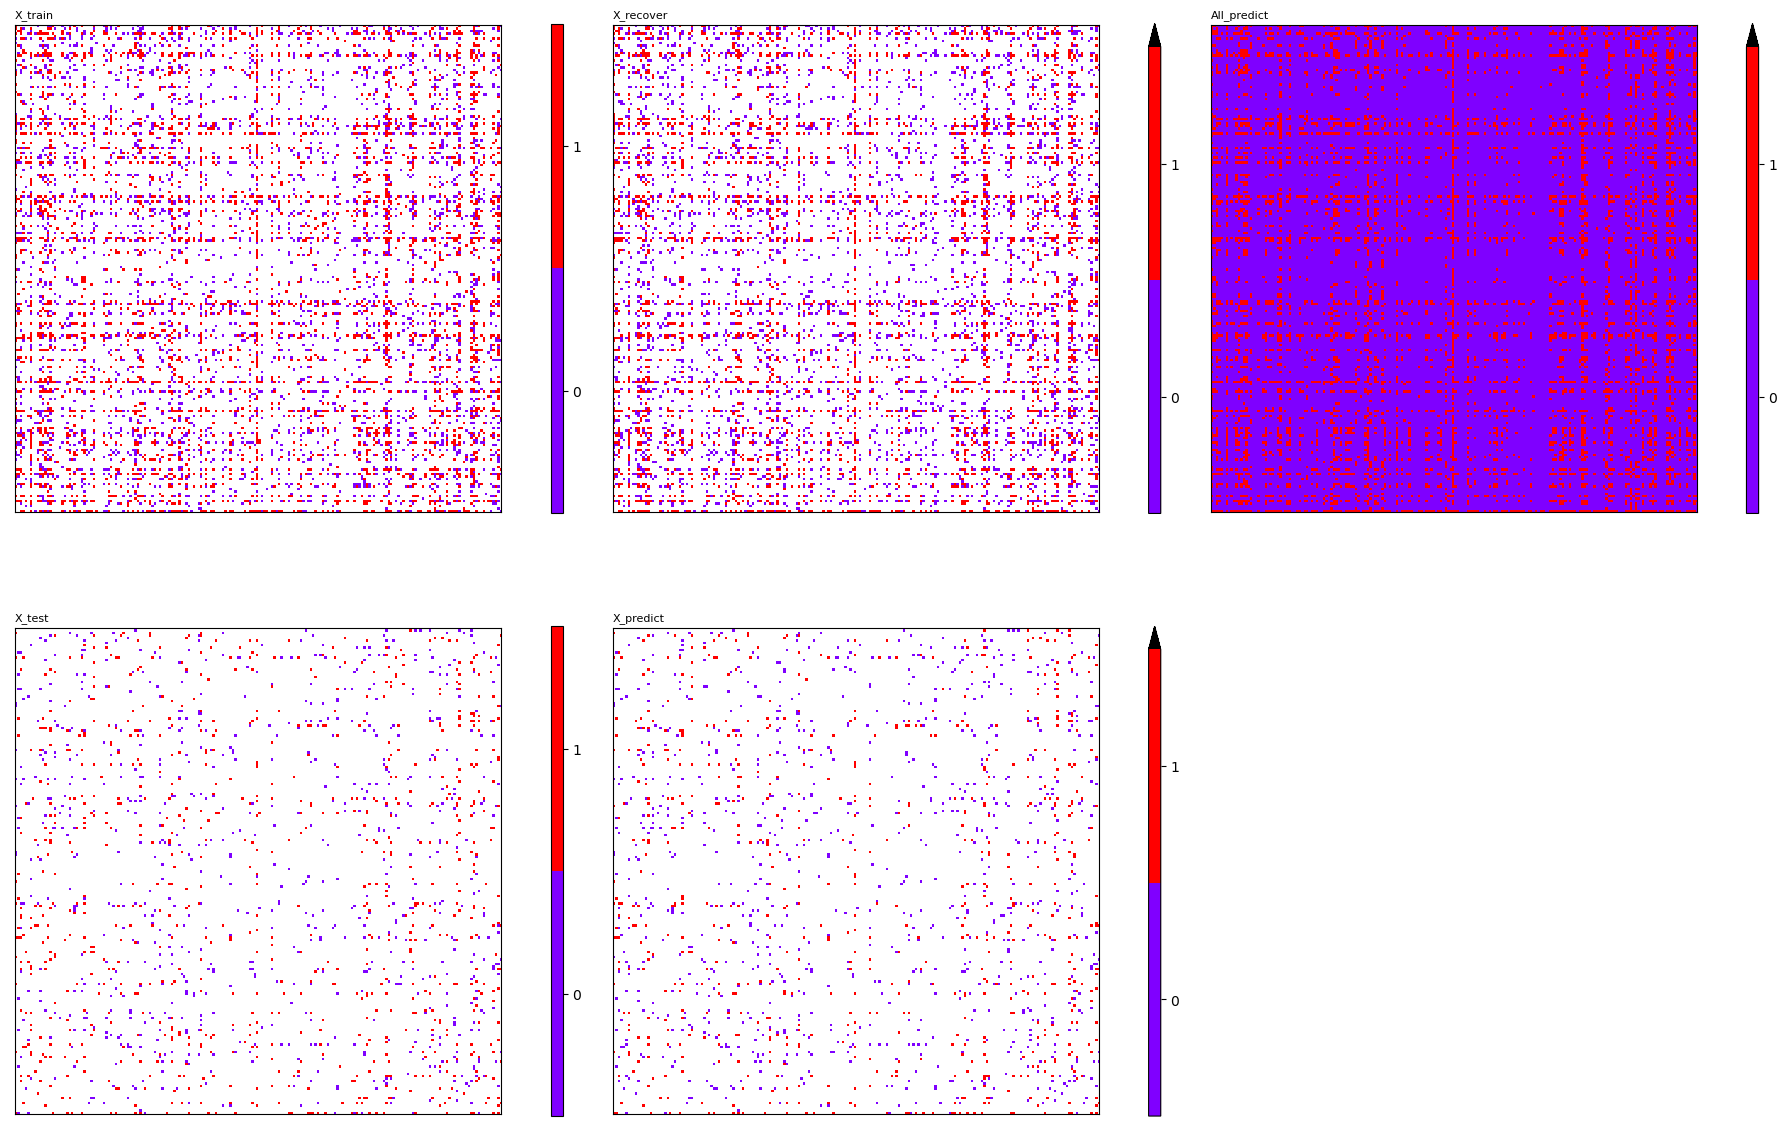

In [25]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False, nonneg=True)
model.fit(X_train)

A, B = model.A_, model.B_
P = A @ B.T # inner product

X_recover = fill_nan(P, X_train)
X_predict = fill_nan(P, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

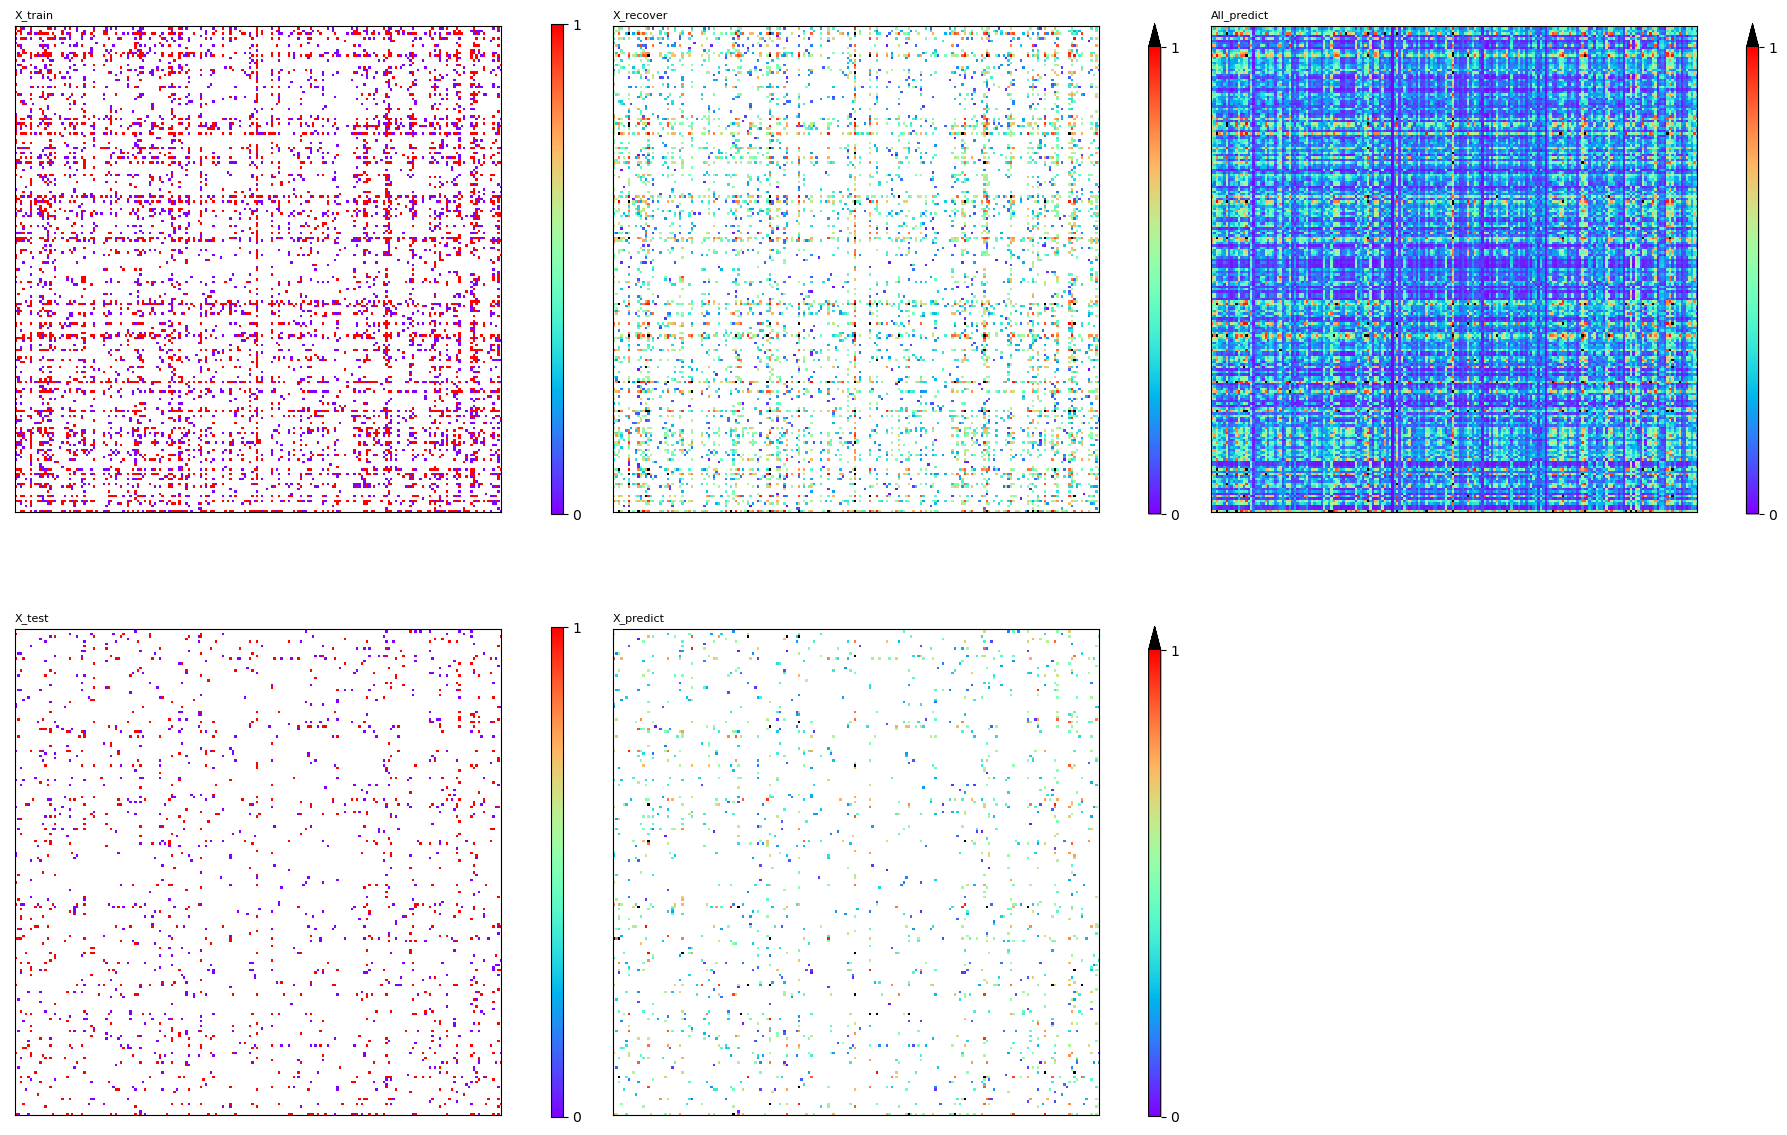

In [26]:
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=False, keep_nan=True)

# cmf-1 manual thresholding

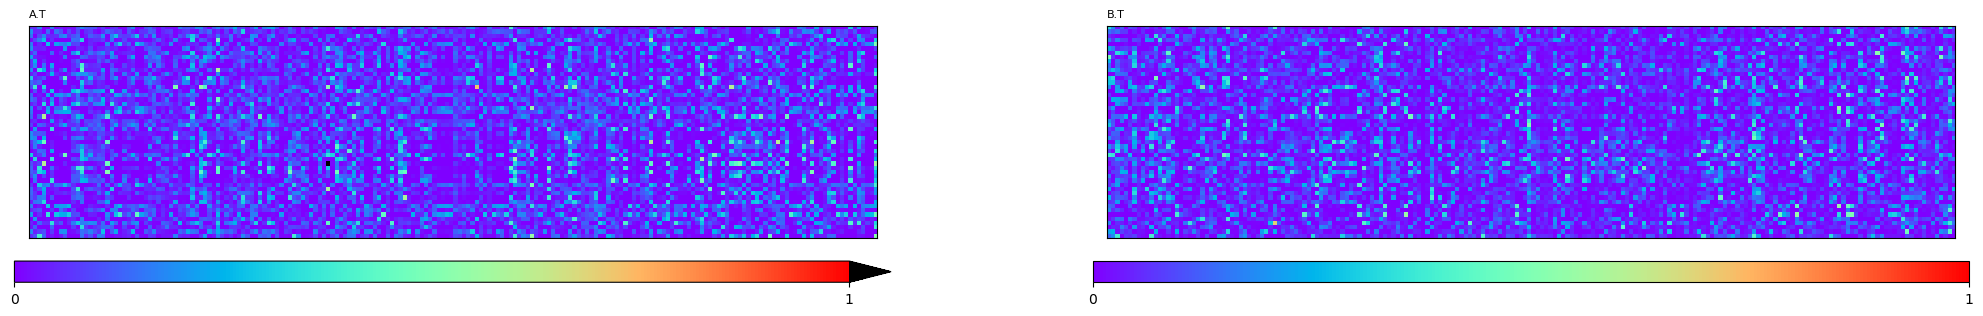

In [29]:
A, B = model.A_, model.B_

rng = [200, 200]

settings = [(A[:rng[0]].T, [0, 0], 'A.T'), 
            (B[:rng[1]].T, [0, 1], 'B.T')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], cmap='rainbow', discrete=False, keep_nan=True)

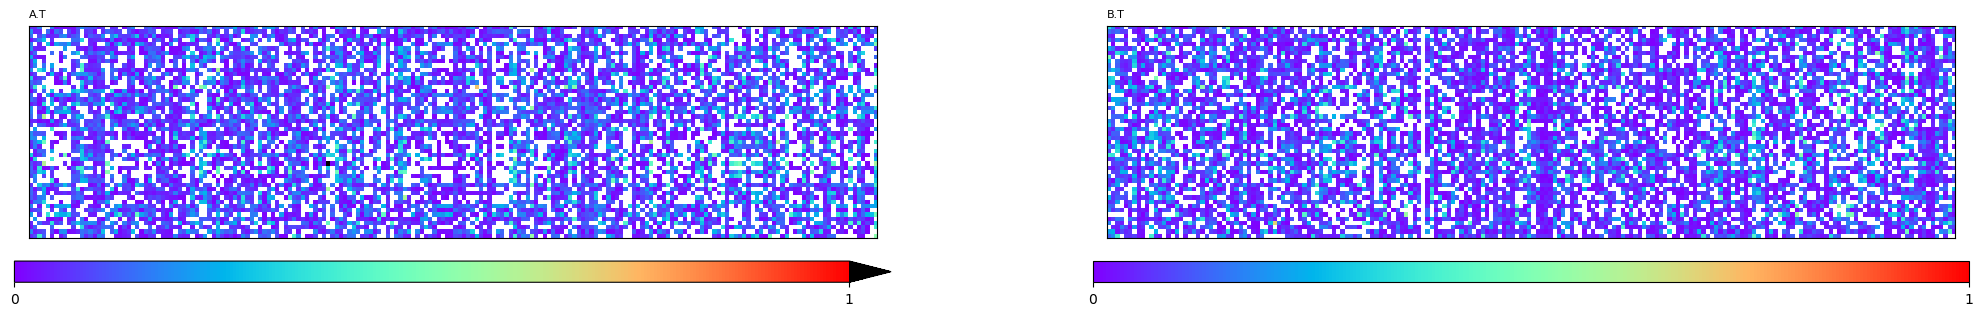

In [31]:
U = A.copy()
U[U == 0] = np.nan
V = B.copy()
V[V == 0] = np.nan

rng = [200, 200]

settings = [(U[:rng[0]].T, [0, 0], 'A.T'), 
            (V[:rng[1]].T, [0, 1], 'B.T')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], cmap='rainbow', discrete=False, keep_nan=True)

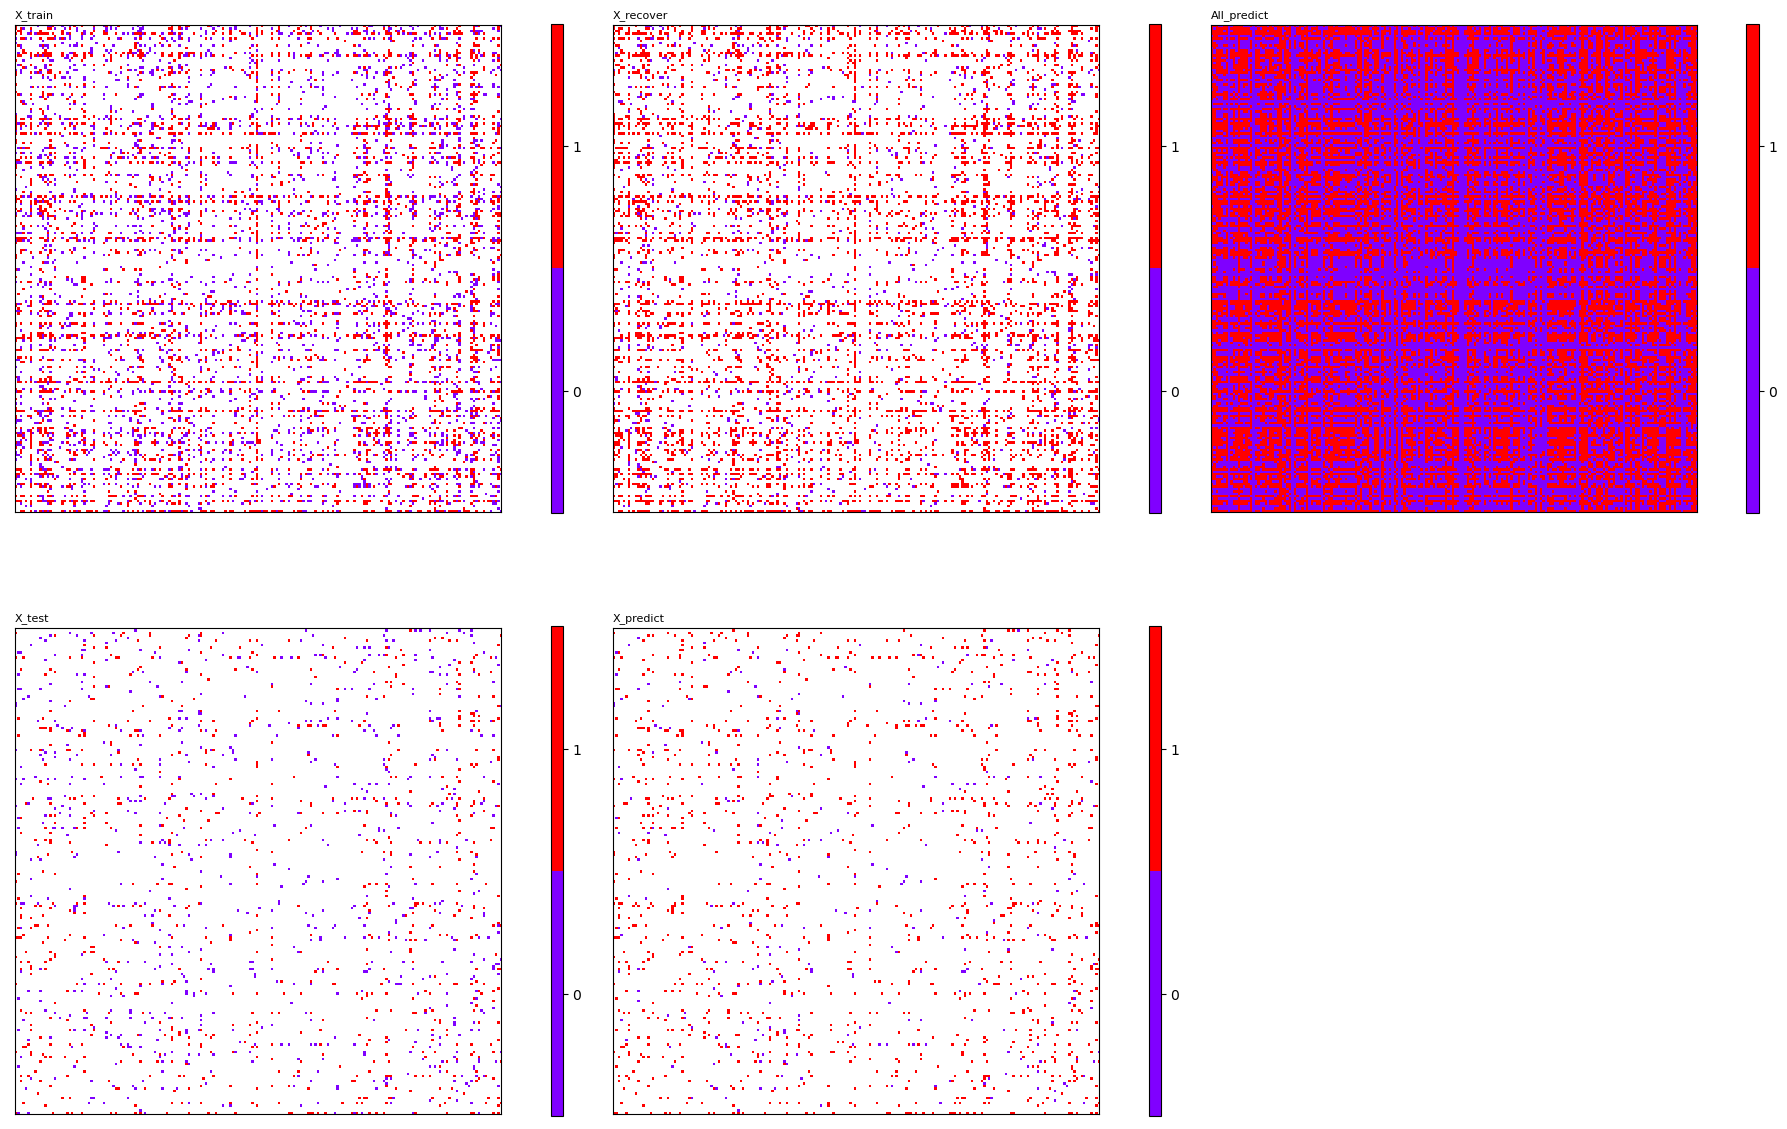

In [54]:
A, B = model.A_, model.B_

U, V = binarize(A, 0.15), binarize(B, 0.15)

# P = A @ B.T
P = matmul(U, V.T, sparse=False, boolean=True)

X_recover = fill_nan(P, X_train)
X_predict = fill_nan(P, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-1 bmf thresholding

In [50]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.4, v=0.4, lamda=10, eps=1e-6, max_iter=1000)
bmf.fit(X_train)

[I] algorithm    : threshold
[I] initial u, v : [0.4, 0.4]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 1000
[I] Missing validation data.
[I] After initialization: max U: 1.500, max V: 0.693
[I] After normalization: max U: 0.767, max V: 0.767
[I] iter: 0, start from [0.400, 0.400], search direction [-0.739, -0.674]
[I] iter: 1, start from [0.356, 0.360], search direction [0.749, 0.663]
[I] iter: 2, start from [0.362, 0.365], search direction [-0.827, -0.562]
[I] iter: 3, start from [0.362, 0.365], search direction [-0.695, 0.719]
[I] iter: 4, start from [0.356, 0.371], search direction [0.555, 0.832]
[W] Stopped in advance: search direction is not a descent direction.


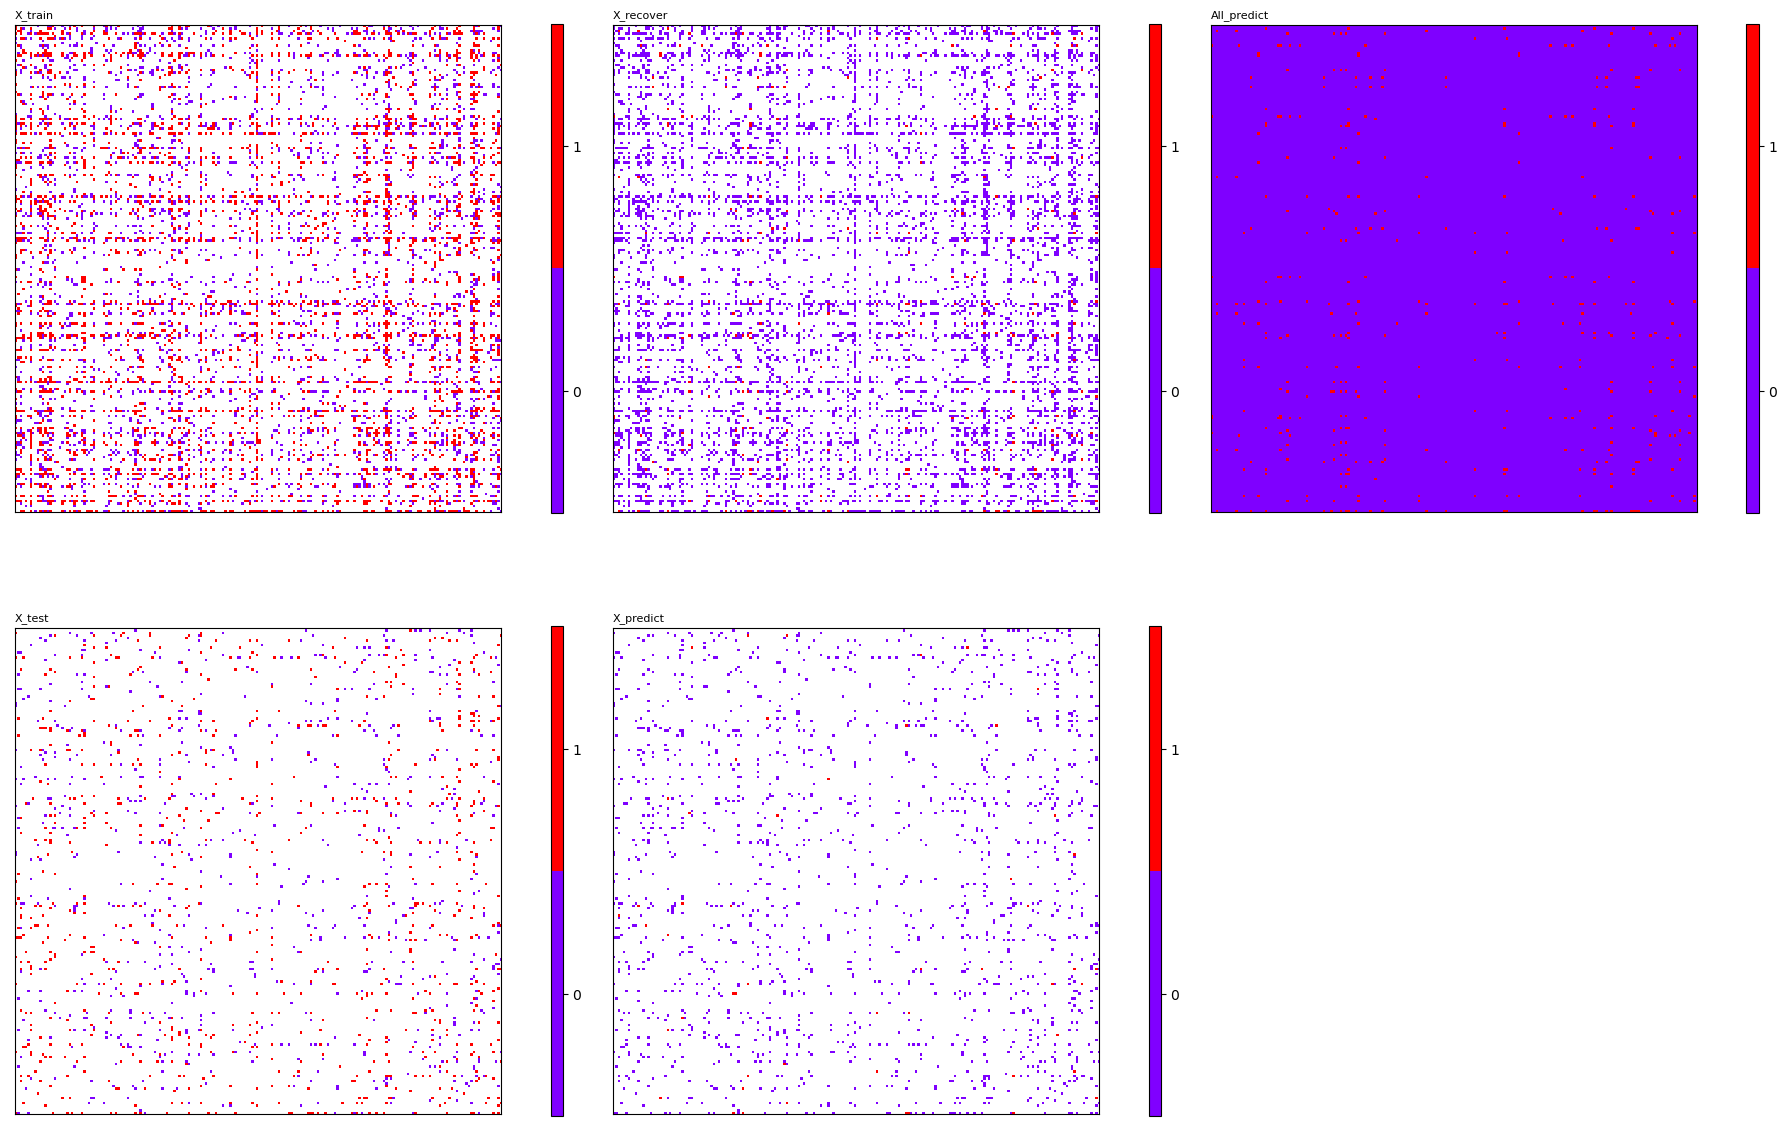

In [41]:
U, V = binarize(A, bmf.u), binarize(B, bmf.v)

# P = A @ B.T
P = matmul(U, V.T, sparse=False, boolean=True)

X_recover = fill_nan(P, X_train)
X_predict = fill_nan(P, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-1 grid thresholding

In [78]:
names = ['u', 'v']
metrics = ['Recall', 'Precision', 'Accuracy', 'Error']
df_results = pd.DataFrame(columns=names+metrics)

grid = np.arange(start=0.10, stop=0.30, step=0.01)

for u in grid:
    for v in grid:
        U, V = binarize(A, u), binarize(B, v)
        # P = matmul(U, V.T, sparse=False, boolean=True)

        U_idx, V_idx, gt_data = to_triplet(X_test)
        pd_num = len(gt_data)
        pd_data = np.zeros(pd_num, dtype=int)
        for i in range(pd_num):
            # pd_data[i] = P[U_idx[i], V_idx[i]]
            pd_data[i] = dot(U[U_idx[i]], V[V_idx[i]], boolean=True)

        results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)
        add_log(df=df_results, line=[u, v]+results, verbose=False)

df_results

u     v   Recall  Precision  Accuracy     Error
0    0.10  0.10  0.98350   0.530718  0.556925  0.443075
1    0.10  0.11  0.97920   0.536827  0.567175  0.432825
2    0.10  0.12  0.97405   0.543100  0.577300  0.422700
3    0.10  0.13  0.97035   0.549478  0.587375  0.412625
4    0.10  0.14  0.96595   0.557273  0.599275  0.400725
..    ...   ...      ...        ...       ...       ...
395  0.29  0.25  0.39320   0.797404  0.646650  0.353350
396  0.29  0.26  0.36080   0.802045  0.635875  0.364125
397  0.29  0.27  0.33685   0.807891  0.628375  0.371625
398  0.29  0.28  0.31360   0.815817  0.621400  0.378600
399  0.29  0.29  0.29030   0.820056  0.613300  0.386700

[400 rows x 6 columns]

In [82]:
row = df_results['Accuracy'].idxmax()
df_results.iloc[row]

u            0.180000
v            0.230000
Recall       0.748000
Precision    0.699752
Accuracy     0.713525
Error        0.286475
Name: 173, dtype: float64

In [79]:
print(df_results.to_string())

        u     v   Recall  Precision  Accuracy     Error
0    0.10  0.10  0.98350   0.530718  0.556925  0.443075
1    0.10  0.11  0.97920   0.536827  0.567175  0.432825
2    0.10  0.12  0.97405   0.543100  0.577300  0.422700
3    0.10  0.13  0.97035   0.549478  0.587375  0.412625
4    0.10  0.14  0.96595   0.557273  0.599275  0.400725
5    0.10  0.15  0.95875   0.564419  0.609425  0.390575
6    0.10  0.16  0.95240   0.571720  0.619475  0.380525
7    0.10  0.17  0.94420   0.579317  0.629275  0.370725
8    0.10  0.18  0.93385   0.586552  0.637800  0.362200
9    0.10  0.19  0.92135   0.593596  0.645275  0.354725
10   0.10  0.20  0.90845   0.601981  0.653900  0.346100
11   0.10  0.21  0.89655   0.609359  0.660900  0.339100
12   0.10  0.22  0.87960   0.616722  0.666475  0.333525
13   0.10  0.23  0.85985   0.624982  0.671950  0.328050
14   0.10  0.24  0.83955   0.634125  0.677575  0.322425
15   0.10  0.25  0.82210   0.642994  0.682825  0.317175
16   0.10  0.26  0.79185   0.650791  0.683475  0

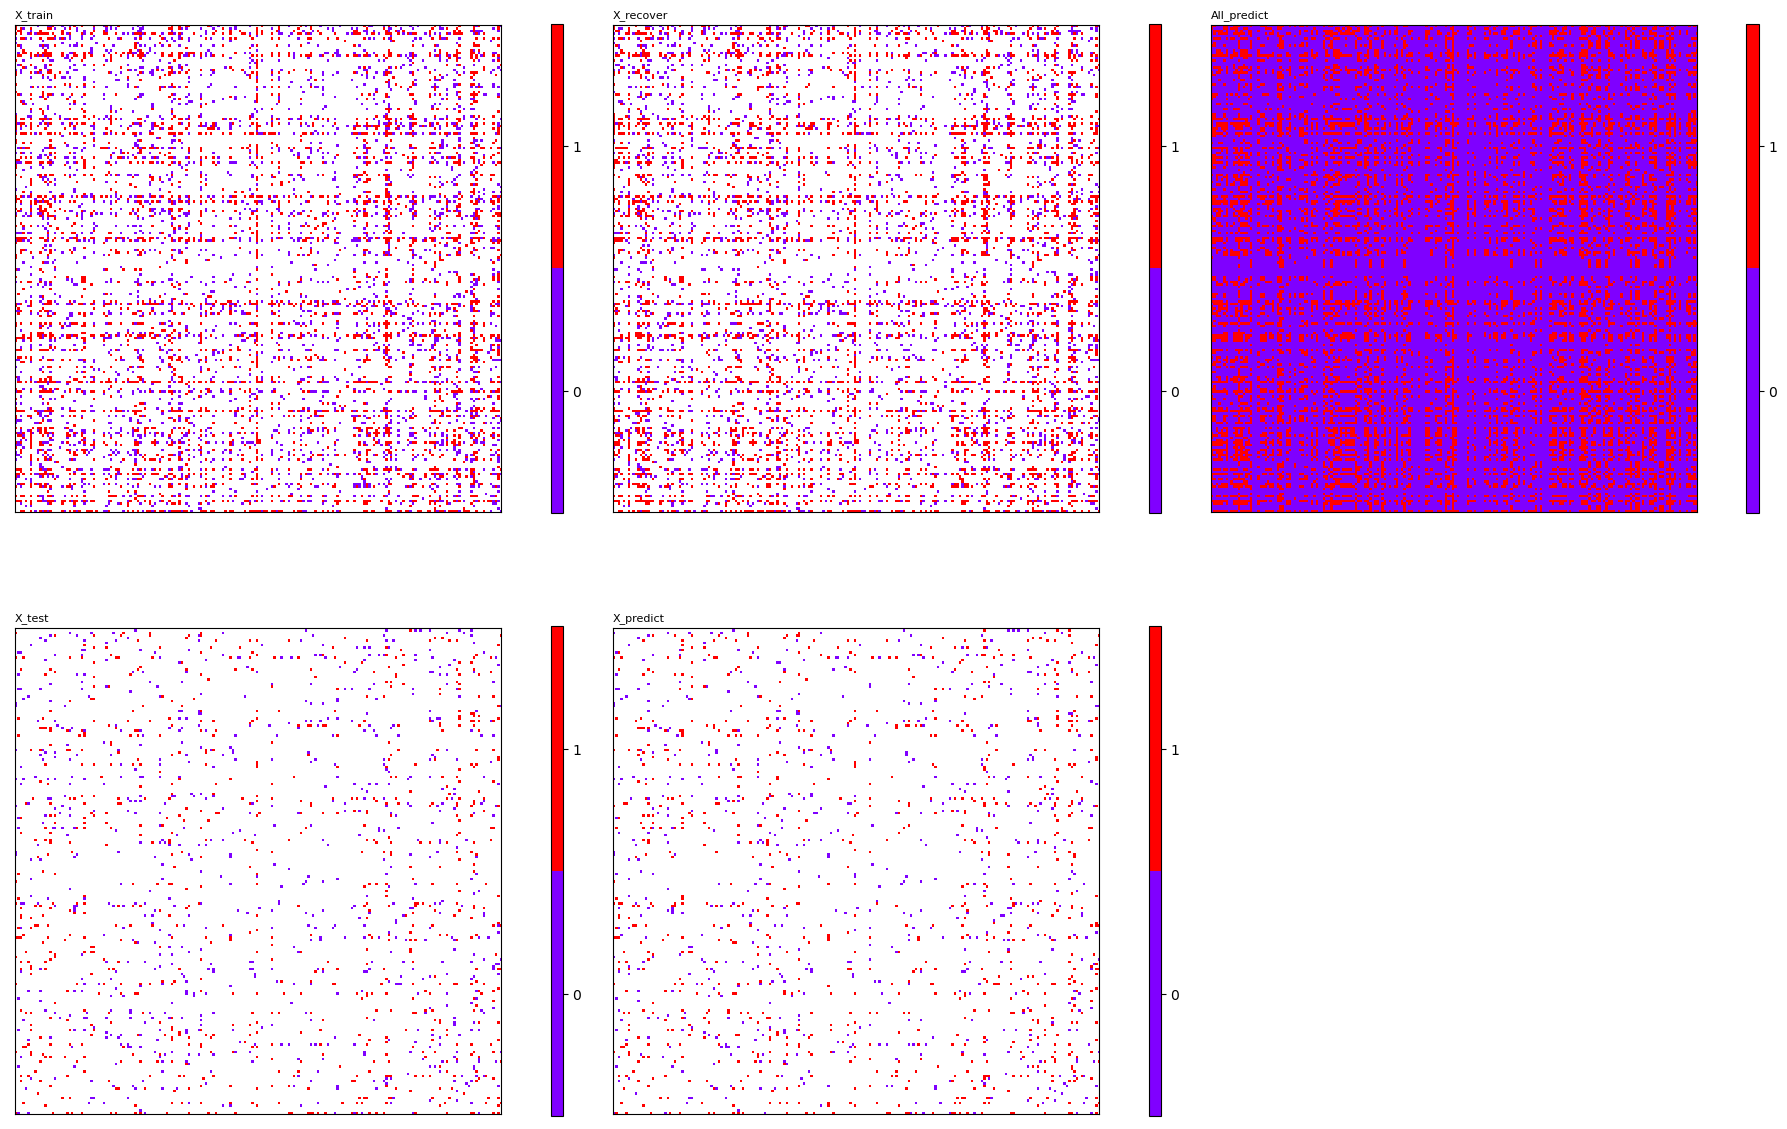

In [83]:
U, V = binarize(A, 0.18), binarize(B, 0.23)

# P = A @ B.T
P = matmul(U, V.T, sparse=False, boolean=True)

X_recover = fill_nan(P, X_train)
X_predict = fill_nan(P, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# bmf thresholding diagnosis

In [38]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.5, v=0.5, lamda=10, eps=1e-6, max_iter=1000)
bmf.fit(X_train)

[I] algorithm    : threshold
[I] initial u, v : [0.5, 0.5]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 1000
[I] Missing validation data.
[I] After initialization: max U: 1.500, max V: 0.693
[I] After normalization: max U: 0.767, max V: 0.767
[I] iter: 0, start from [0.500, 0.500], search direction [-0.695, -0.719]
[I] iter: 1, start from [0.365, 0.361], search direction [-0.566, 0.825]
[I] iter: 2, start from [0.363, 0.364], search direction [-0.850, -0.527]
[I] iter: 3, start from [0.363, 0.364], search direction [-0.580, 0.814]
[I] iter: 4, start from [0.360, 0.367], search direction [-0.862, -0.508]
[I] iter: 5, start from [0.360, 0.367], search direction [0.561, 0.828]
[W] Stopped in advance: search direction is not a descent direction.


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Text(0.5, 0, 'z')

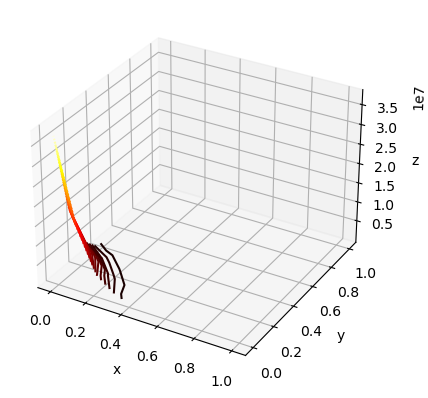

In [16]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 10
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
Z = np.zeros([N, N])
X, Y = np.meshgrid(x, y)
for i in tqdm(range(N)):
    for j in range(N):
        Z[i, j] = bmf.F([X[i, j], Y[i, j]])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='hot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Text(0.5, 0, 'z')

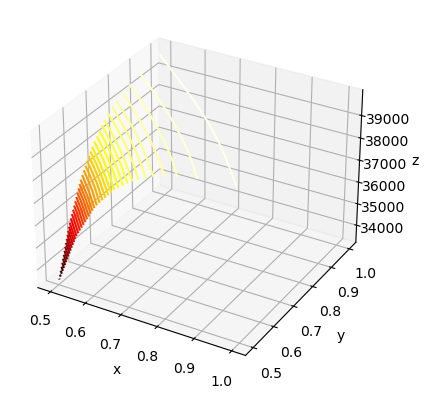

In [17]:
N = 10
x = np.linspace(0.5, 1, N)
y = np.linspace(0.5, 1, N)
Z = np.zeros([N, N])
X, Y = np.meshgrid(x, y)
for i in tqdm(range(N)):
    for j in range(N):
        Z[i, j] = bmf.F([X[i, j], Y[i, j]])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='hot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

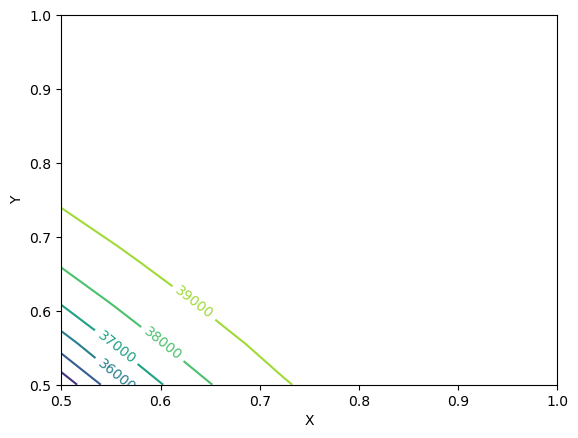

In [18]:
cp = plt.contour(X, Y, Z)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# cmf-3 (no bias, nonneg)

In [88]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False, 
            user_bias=False, item_bias=False, 
            center=False, center_U=False, center_I=False,  
            nonneg=True, nonneg_C=True, nonneg_D=True, 
            NA_as_zero=False, NA_as_zero_user=True, NA_as_zero_item=True)
model.fit(X=X_train.tocoo(), U=Y.tocoo(), I=Z.tocoo().T)

A, B = model.A_, model.B_
P = A @ B.T

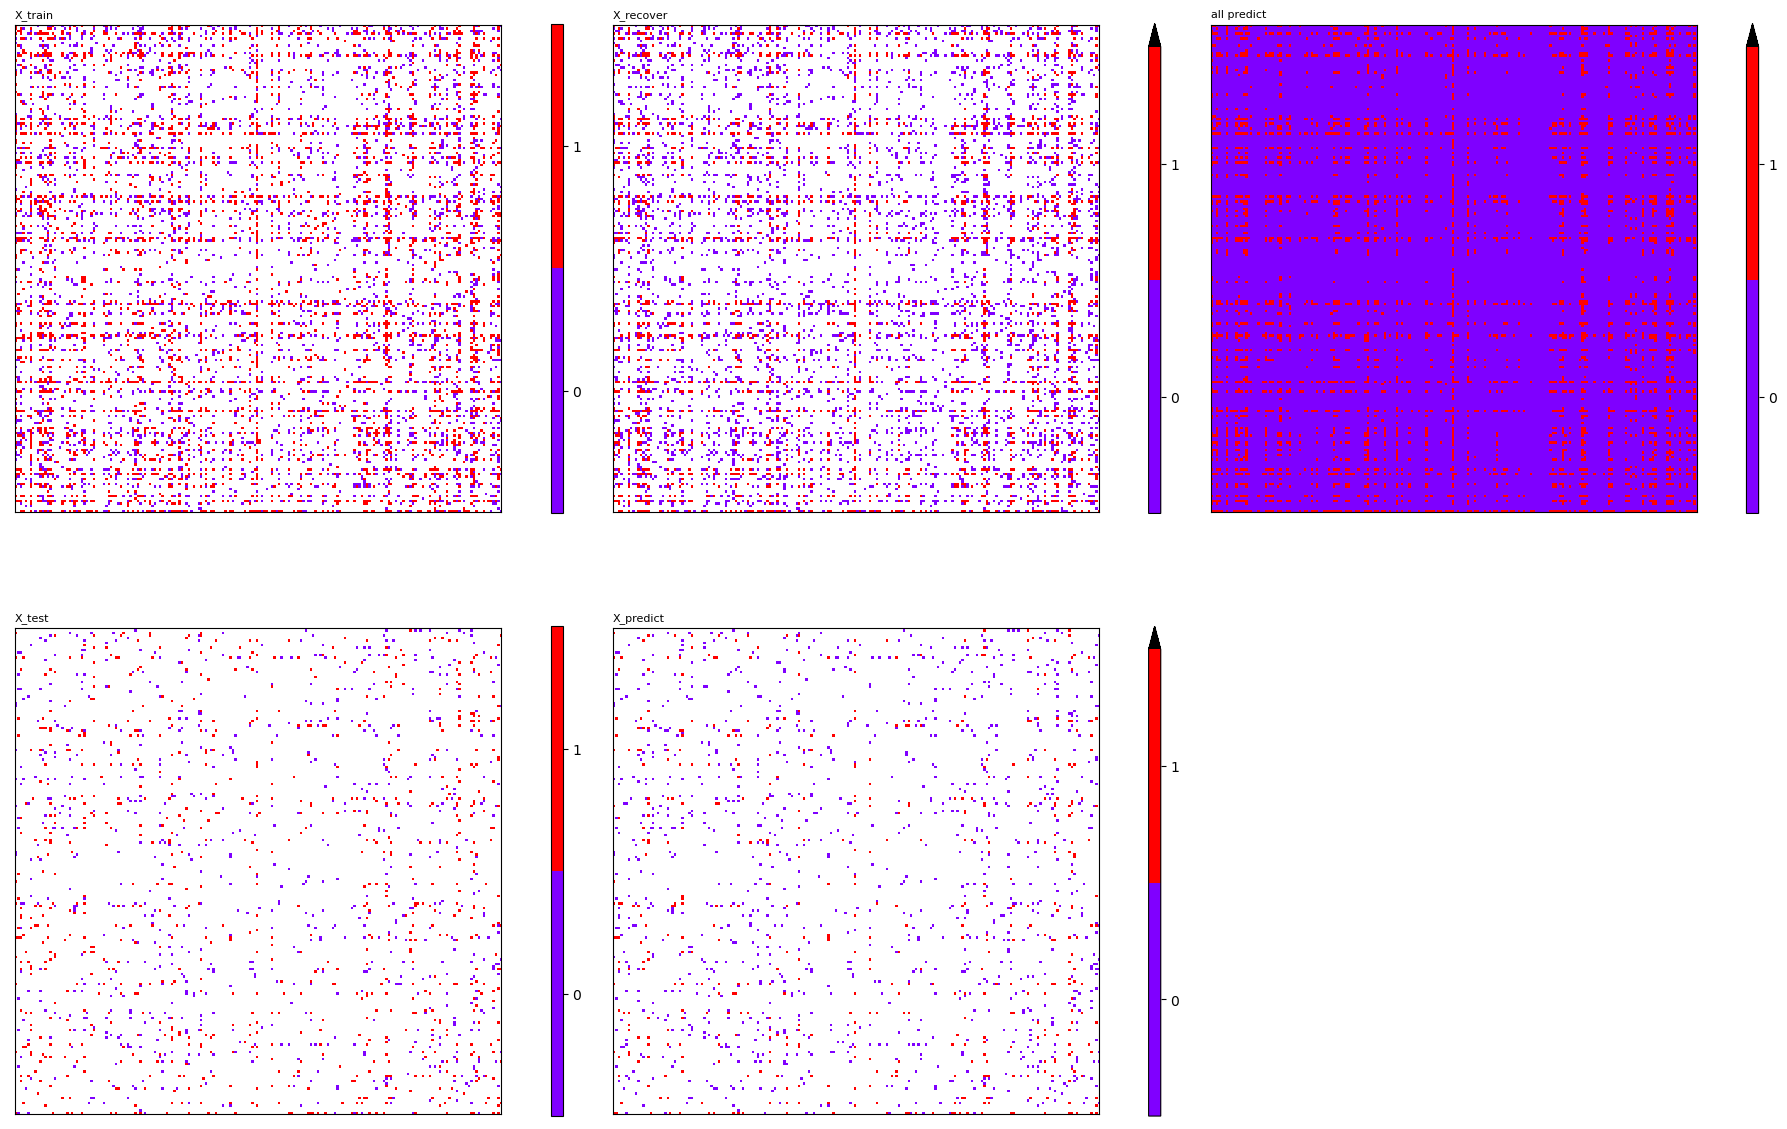

In [89]:
show_results(means=False)

In [86]:
A, B, C, D = model.A_, model.B_, model.C_, model.D_
(A.max(), B.max(), C.max(), D.max())

(0.5870083, 0.554606, 0.42806563, 0.3602208)

# cmf-3 A, B only

In [93]:
names = ['u', 'v']
metrics = ['Recall', 'Precision', 'Accuracy', 'Error']
df_results = pd.DataFrame(columns=names+metrics)

grid = np.arange(start=0.10, stop=0.30, step=0.01)

for u in grid:
    for v in grid:
        U, V = binarize(A, u), binarize(B, v)
        # P = matmul(U, V.T, sparse=False, boolean=True)

        U_idx, V_idx, gt_data = to_triplet(X_test)
        pd_num = len(gt_data)
        pd_data = np.zeros(pd_num, dtype=int)
        for i in range(pd_num):
            # pd_data[i] = P[U_idx[i], V_idx[i]]
            pd_data[i] = dot(U[U_idx[i]], V[V_idx[i]], boolean=True)

        results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)
        add_log(df=df_results, line=[u, v]+results, verbose=False)

df_results

u     v   Recall  Precision  Accuracy     Error
0    0.10  0.10  0.87140   0.572555  0.610425  0.389575
1    0.10  0.11  0.84625   0.585985  0.624175  0.375825
2    0.10  0.12  0.81665   0.598235  0.634100  0.365900
3    0.10  0.13  0.78185   0.611537  0.642600  0.357400
4    0.10  0.14  0.74020   0.624720  0.647775  0.352225
..    ...   ...      ...        ...       ...       ...
395  0.29  0.25  0.01210   0.899628  0.505375  0.494625
396  0.29  0.26  0.01095   0.893878  0.504825  0.495175
397  0.29  0.27  0.01005   0.897321  0.504450  0.495550
398  0.29  0.28  0.00895   0.899497  0.503975  0.496025
399  0.29  0.29  0.00845   0.903743  0.503775  0.496225

[400 rows x 6 columns]

In [94]:
row = df_results['Accuracy'].idxmax()
df_results.iloc[row]

u            0.140000
v            0.130000
Recall       0.654400
Precision    0.667823
Accuracy     0.664450
Error        0.335550
Name: 83, dtype: float64

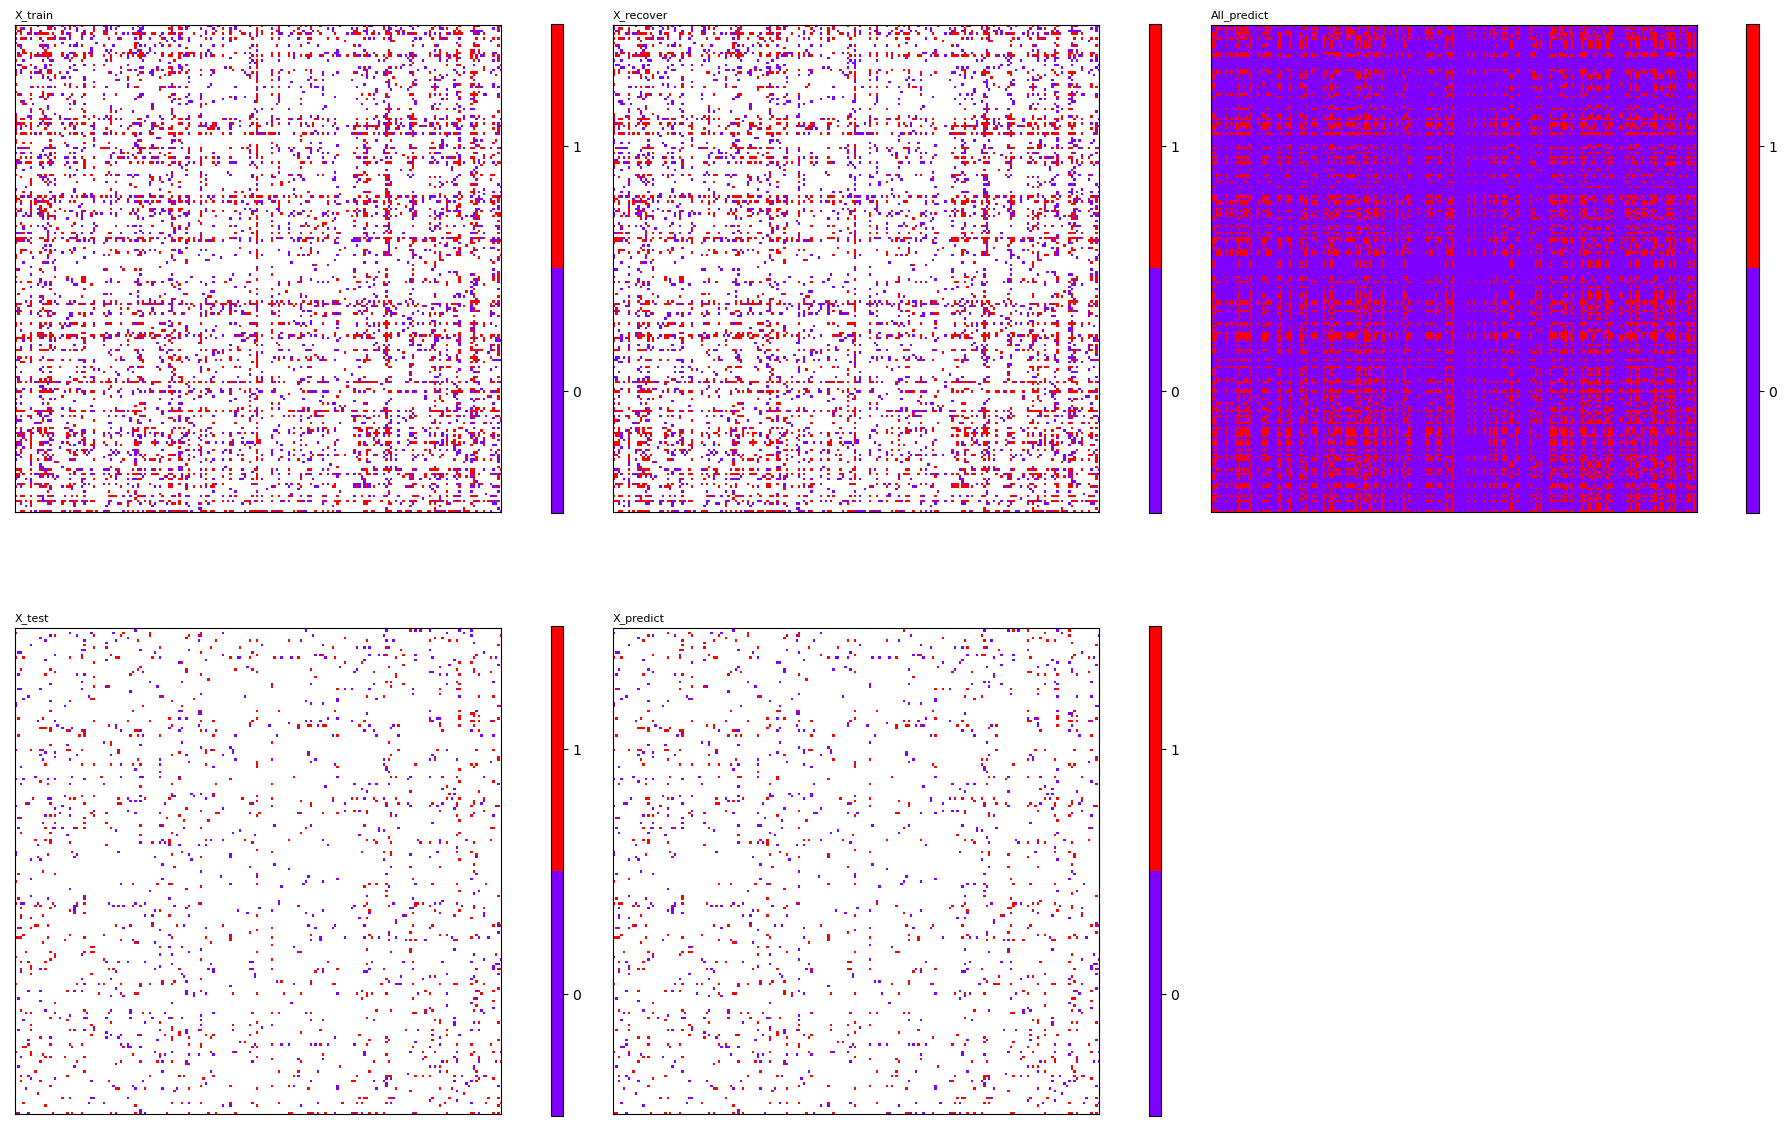

In [95]:
U, V = binarize(A, 0.14), binarize(B, 0.13)

# P = A @ B.T
P = matmul(U, V.T, sparse=False, boolean=True)

X_recover = fill_nan(P, X_train)
X_predict = fill_nan(P, X_test)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'All_predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-3 A, B, C, D

In [97]:
(A.shape, B.shape, C.shape, D.shape)

((943, 50), (1682, 50), (81, 50), (26, 50))

In [100]:
import itertools
from tqdm import tqdm

grid = np.arange(start=0.10, stop=0.20, step=0.01)
grids = list(itertools.product(*[grid, grid, grid, grid]))


names = ['a', 'b', 'c', 'd'] + list(np.arange(1, 10).astype(str))
metrics = ['Recall', 'Precision', 'Accuracy']
df_results = pd.DataFrame(columns=names)


for a, b, c, d in tqdm(grids):
    T, U, V, W = binarize(C, c), binarize(A, a), binarize(B, b), binarize(D, d)

    #
    U_idx, V_idx, gt_data = to_triplet(X_test)
    pd_num = len(gt_data)
    pd_data = np.zeros(pd_num, dtype=int)
    for i in range(pd_num):
        pd_data[i] = dot(U[U_idx[i]], V[V_idx[i]], boolean=True)
    X_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)

    #
    gt_data = to_sparse(Y, type='csr')
    pd_data = matmul(U=U, V=T.T, sparse=True, boolean=True)
    Y_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)

    #
    gt_data = to_sparse(Z.T, type='csr')
    pd_data = matmul(U=V, V=W.T, sparse=True, boolean=True)
    Z_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)

    #
    add_log(df=df_results, line=[a, b, c, d]+X_results+Y_results+Z_results, verbose=False)

df_results

100%|██████████| 10000/10000 [49:49<00:00,  3.35it/s] 


a     b     c     d       1         2         3         4         5  \
0     0.10  0.10  0.10  0.10  0.8714  0.572555  0.610425  0.644184  0.193046   
1     0.10  0.10  0.10  0.11  0.8714  0.572555  0.610425  0.644184  0.193046   
2     0.10  0.10  0.10  0.12  0.8714  0.572555  0.610425  0.644184  0.193046   
3     0.10  0.10  0.10  0.13  0.8714  0.572555  0.610425  0.644184  0.193046   
4     0.10  0.10  0.10  0.14  0.8714  0.572555  0.610425  0.644184  0.193046   
...    ...   ...   ...   ...     ...       ...       ...       ...       ...   
9995  0.19  0.19  0.19  0.15  0.2237  0.821219  0.587500  0.143470  0.372957   
9996  0.19  0.19  0.19  0.16  0.2237  0.821219  0.587500  0.143470  0.372957   
9997  0.19  0.19  0.19  0.17  0.2237  0.821219  0.587500  0.143470  0.372957   
9998  0.19  0.19  0.19  0.18  0.2237  0.821219  0.587500  0.143470  0.372957   
9999  0.19  0.19  0.19  0.19  0.2237  0.821219  0.587500  0.143470  0.372957   

             6         7         8         9  
0     0.860349  0.490449  0.184749  0.753544  
1     0.860349  0.481518  0.193115  0.766761  
2     0.860349  0.448276  0.221202  0.803668  
3     0.860349  0.442570  0.224827  0.807967  
4     0.860349  0.413793  0.257925  0.836230  
...        ...       ...       ...       ...  
9995  0.949714  0.150087  0.270451  0.884341  
9996  0.949714  0.149839  0.274421  0.885118  
9997  0.949714  0.144877  0.279962  0.886833  
9998  0.949714  0.136194  0.292488  0.890012  
9999  0.949714  0.127512  0.310574  0.893488  

[10000 rows x 13 columns]

In [104]:
rows = []

for i in list(np.arange(1, 10).astype(str)):
    row = df_results[i].idxmax()
    rows.append(row)

rows

[0, 9900, 4300, 0, 8090, 9090, 0, 909, 909]

In [106]:
df_results.loc[rows]

a     b     c     d        1         2         3         4         5  \
0     0.10  0.10  0.10  0.10  0.87140  0.572555  0.610425  0.644184  0.193046   
9900  0.19  0.19  0.10  0.10  0.22370  0.821219  0.587500  0.277508  0.209403   
4300  0.14  0.13  0.10  0.10  0.65440  0.667823  0.664450  0.503572  0.201073   
0     0.10  0.10  0.10  0.10  0.87140  0.572555  0.610425  0.644184  0.193046   
8090  0.18  0.10  0.19  0.10  0.55370  0.677599  0.645125  0.175479  0.376225   
9090  0.19  0.10  0.19  0.10  0.49715  0.689289  0.636525  0.143470  0.372957   
0     0.10  0.10  0.10  0.10  0.87140  0.572555  0.610425  0.644184  0.193046   
909   0.10  0.19  0.10  0.19  0.49045  0.687386  0.633700  0.644184  0.193046   
909   0.10  0.19  0.10  0.19  0.49045  0.687386  0.633700  0.644184  0.193046   

             6         7         8         9  
0     0.860349  0.490449  0.184749  0.753544  
9900  0.918909  0.181593  0.192076  0.854157  
4300  0.885603  0.378318  0.187577  0.791663  
0     0.860349  0.490449  0.184749  0.753544  
8090  0.948902  0.490449  0.184749  0.753544  
9090  0.949714  0.490449  0.184749  0.753544  
0     0.860349  0.490449  0.184749  0.753544  
909   0.860349  0.127512  0.310574  0.893488  
909   0.860349  0.127512  0.310574  0.893488

# cmf-3 auto grid search

In [ ]:
matrices = ['A', 'B', 'C', 'D']
columns = ['a', 'b', 'c', 'd']
metrics = ['Recall', 'Precision', 'Accuracy', 'F1']
for mat in matrices:
    for m in metrics:
        columns.append(mat + '_' + m)

mat_max = [A.max(), B.max(), C.max(), D.max()]

# init
a, b, c, d = mat_max / 5
T, U, V, W = binarize(C, c), binarize(A, a), binarize(B, b), binarize(D, d)

X_results = predict_X()
Y_results = predict_Y()
Z_results = predict_Z()

step_size = 0.2

while True:
    a, b, c, d = mat_max / 5
    for i in range(4):
        if i == 0: # update U (A under different a)
            for t in np.arange(start=0.1, stop=mat_max[i], step=step_size):
                a = t
                X_results = predict_X()
                Y_results = predict_Y()

In [ ]:
import itertools
from tqdm import tqdm

# grid = np.arange(start=0.10, stop=0.20, step=0.01)
# grids = list(itertools.product(*[grid, grid, grid, grid]))

matrices = ['A', 'B', 'C', 'D']
columns = ['a', 'b', 'c', 'd']
metrics = ['Recall', 'Precision', 'Accuracy', 'F1']
for mat in matrices:
    for m in metrics:
        columns.append(mat + '_' + m)

df_results = pd.DataFrame(columns=columns)


for a, b, c, d in tqdm(grids):
    T, U, V, W = binarize(C, c), binarize(A, a), binarize(B, b), binarize(D, d)

    add_log(df=df_results, line=[a, b, c, d]+X_results+Y_results+Z_results, verbose=False)

df_results

In [2]:
def predict_X():
    U_idx, V_idx, gt_data = to_triplet(X_test)
    pd_num = len(gt_data)
    pd_data = np.zeros(pd_num, dtype=int)
    for i in range(pd_num):
        pd_data[i] = dot(U[U_idx[i]], V[V_idx[i]], boolean=True)
    X_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)
    return X_results

def reconstruct_Y():
    gt_data = to_sparse(Y, type='csr')
    pd_data = matmul(U=U, V=T.T, sparse=True, boolean=True)
    Y_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)
    return Y_results

def reconstruct_Z():
    gt_data = to_sparse(Z.T, type='csr')
    pd_data = matmul(U=V, V=W.T, sparse=True, boolean=True)
    Z_results = get_metrics(gt=gt_data, pd=pd_data, metrics=metrics)
    return Z_results

In [50]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.5, v=0.5, lamda=10, eps=1e-6, max_iter=200)
bmf.fit(X_train, verbose=True, display=False)

[I] algorithm    : threshold
[I] initial u, v : [0.5, 0.5]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 200
[I] verbose      : True
[I] display      : False
[W] Missing validation data.
[I] After initialization: max U: 0.588, max V: 50.991
[I] After normalization: max U: 2.090, max V: 2.090
[W] Normalization failed. Re-try will help.
[I] iter: 0, start from [0.500, 0.500], search direction [-0.708, -0.706]
[I] [I] Wolfe line search for iter   : 0
[I]     num of function evals made   : 8
[I]     num of gradient evals made   : 3
[I]     function value update        : 37430.344 -> 16897.767
[I]     threshold update             : [0.500, 0.500] -> [0.334, 0.334]
[I]     threshold difference         : 0.235
[I] iter: 1, start from [0.334, 0.334], search direction [0.833, 0.553]
[I] [I] Wolfe line search for iter   : 1
[I]     num of function evals made   : 8
[I]     num of gradient evals made   : 1
[I]     function value update        : 16897.767 -> 16893.815
[I]     th

c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


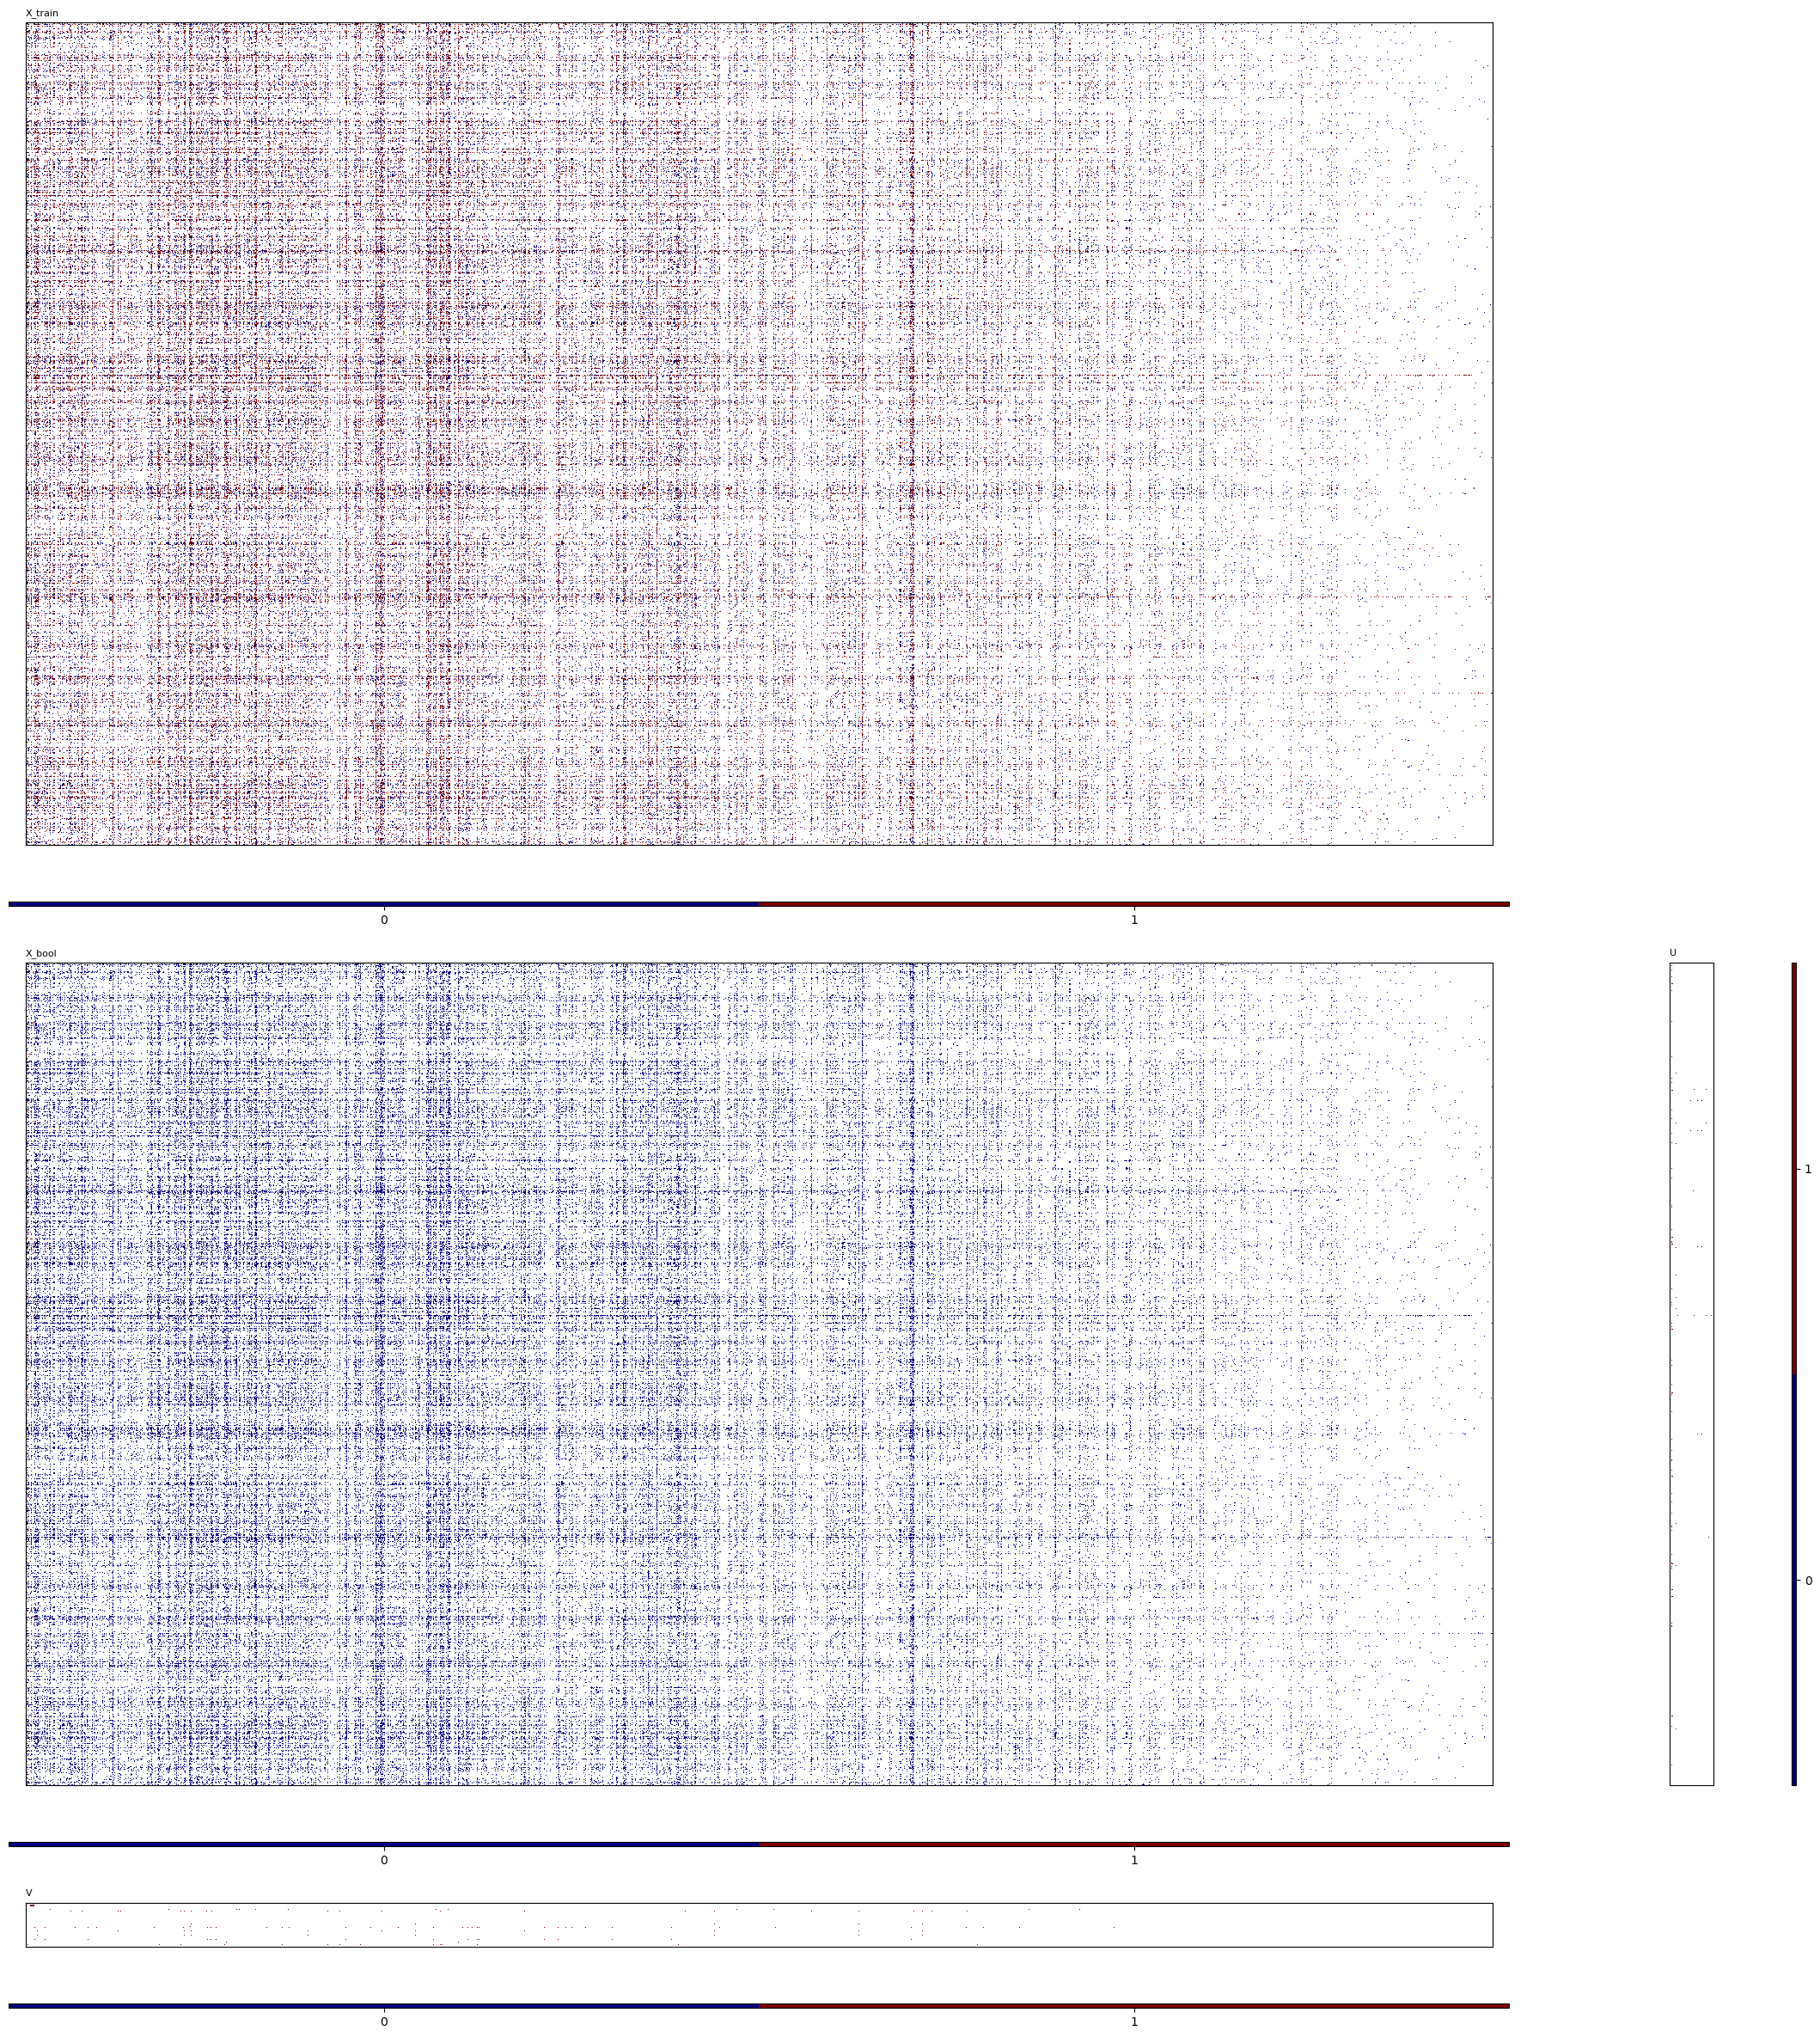

In [44]:
X_real = bmf.U @ bmf.V.T
X_bool = matmul(bmf.U, bmf.V.T, sparse=True, boolean=True)

X = fill_nan(X_bool, X_train)
V = bmf.V.T.copy()
V[V == 0] = np.nan
U = bmf.U.copy()
U[U == 0] = np.nan

L = 200

settings = [(X_train, [0, 0], 'X_train'), 
            (X, [1, 0], 'X_bool'), 
            (V, [2, 0], 'V'), 
            (U, [1, 1], 'U')]
show_matrix(settings=settings, scaling=2, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

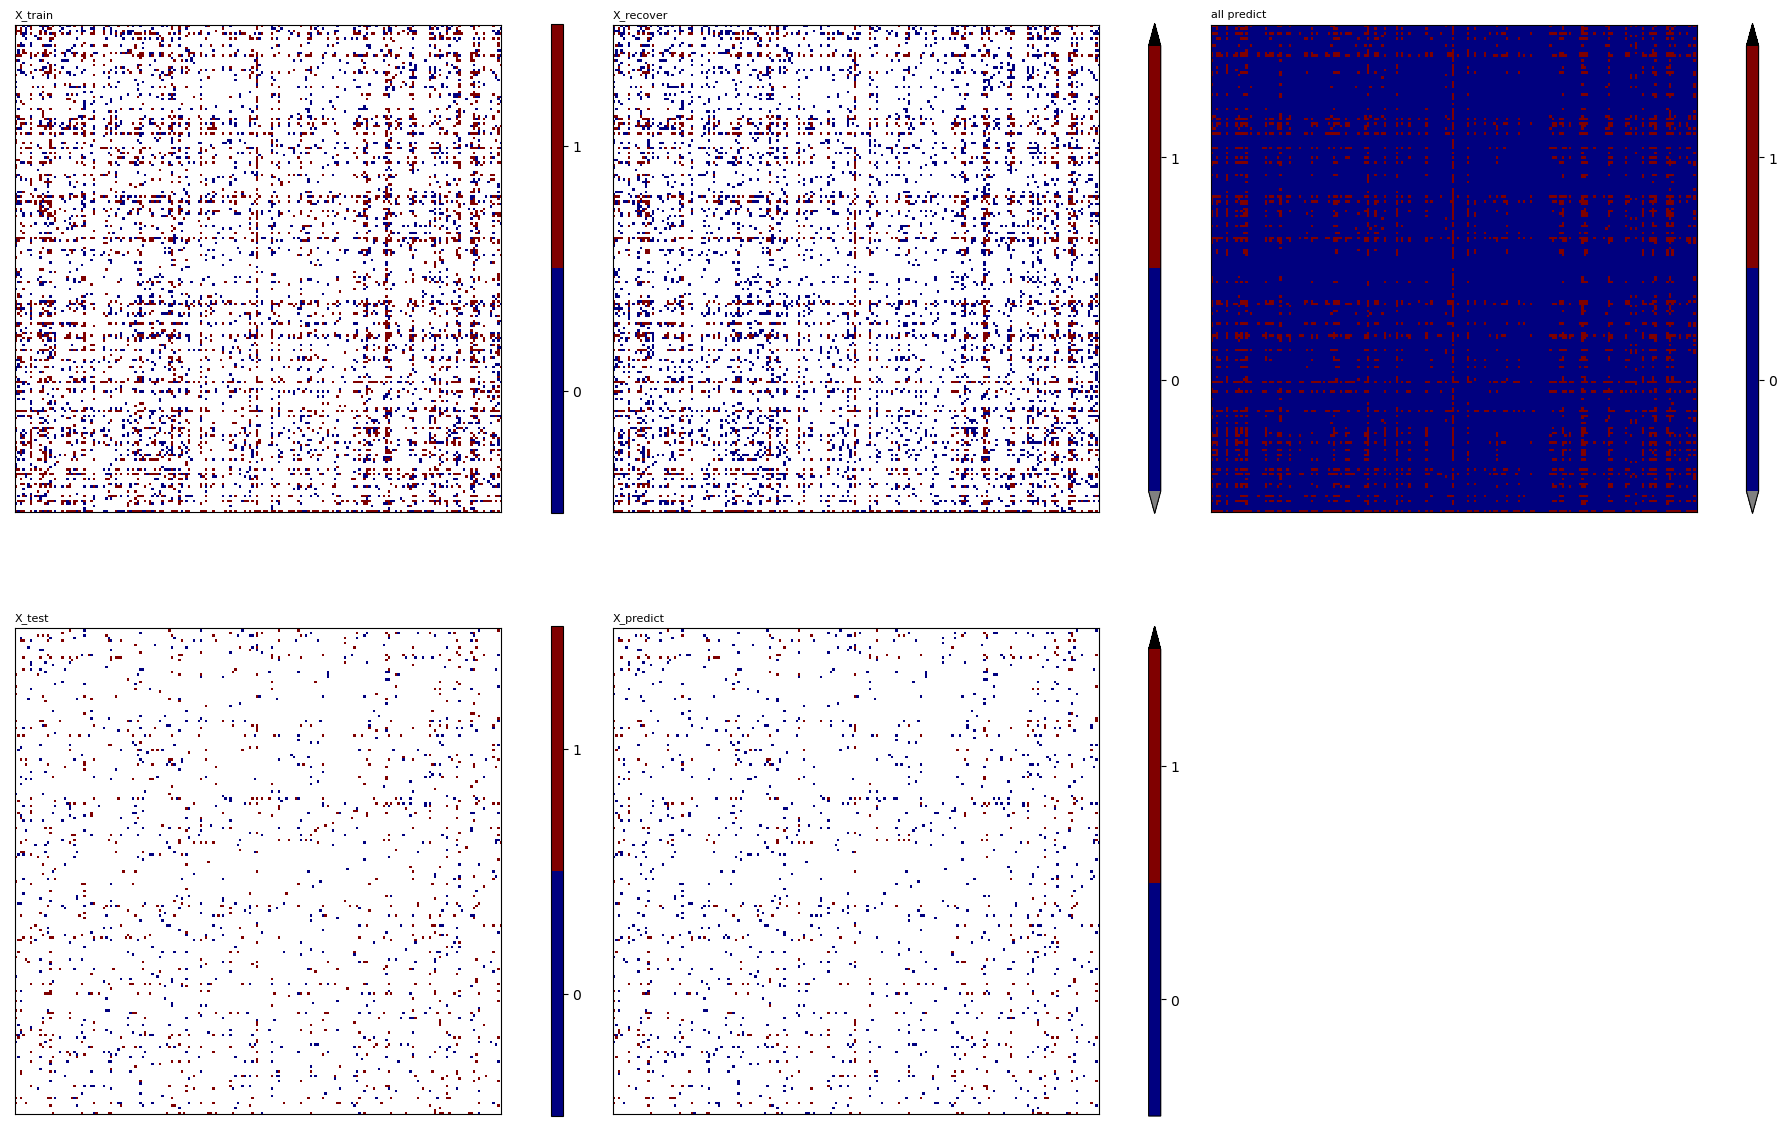

In [21]:
A, B, C, D = model.A_, model.B_, model.C_, model.D_
P = A @ B.T
Q = A @ C.T # user
R = D @ B.T # item

rows, cols = X_train.tocoo().row, X_train.tocoo().col
X_recover = np.empty(shape=X_train.shape)
X_recover.fill(np.nan)
for i in range(len(rows)):
    X_recover[rows[i], cols[i]] = P[rows[i], cols[i]]
X_recover = csr_matrix(X_recover)

rows, cols = X_test.tocoo().row, X_test.tocoo().col
X_predict = np.empty(shape=X_test.shape)
X_predict.fill(np.nan)
for i in range(len(rows)):
    X_predict[rows[i], cols[i]] = P[rows[i], cols[i]]
X_predict = csr_matrix(X_predict)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'all predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

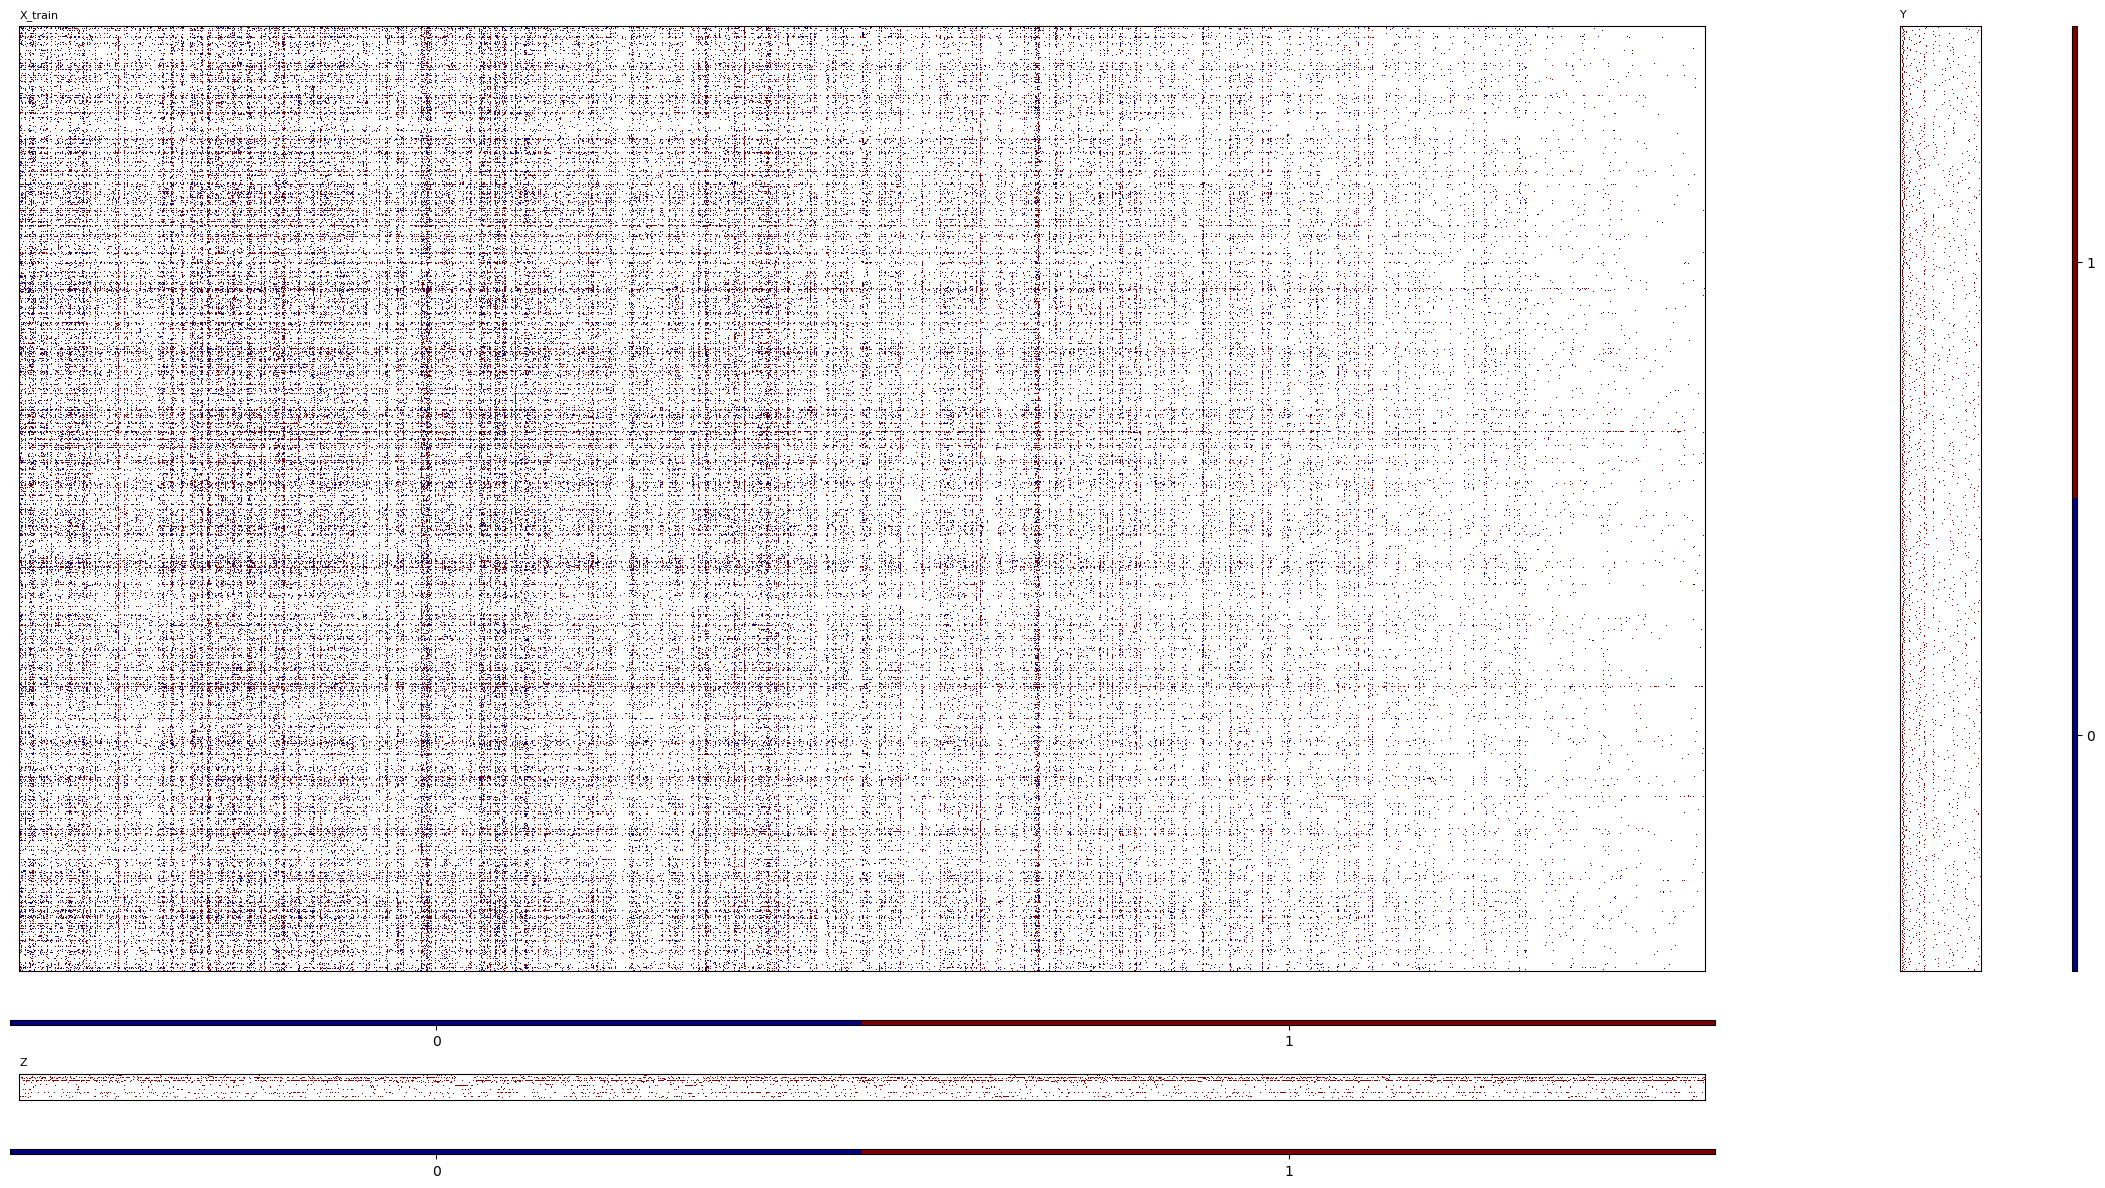

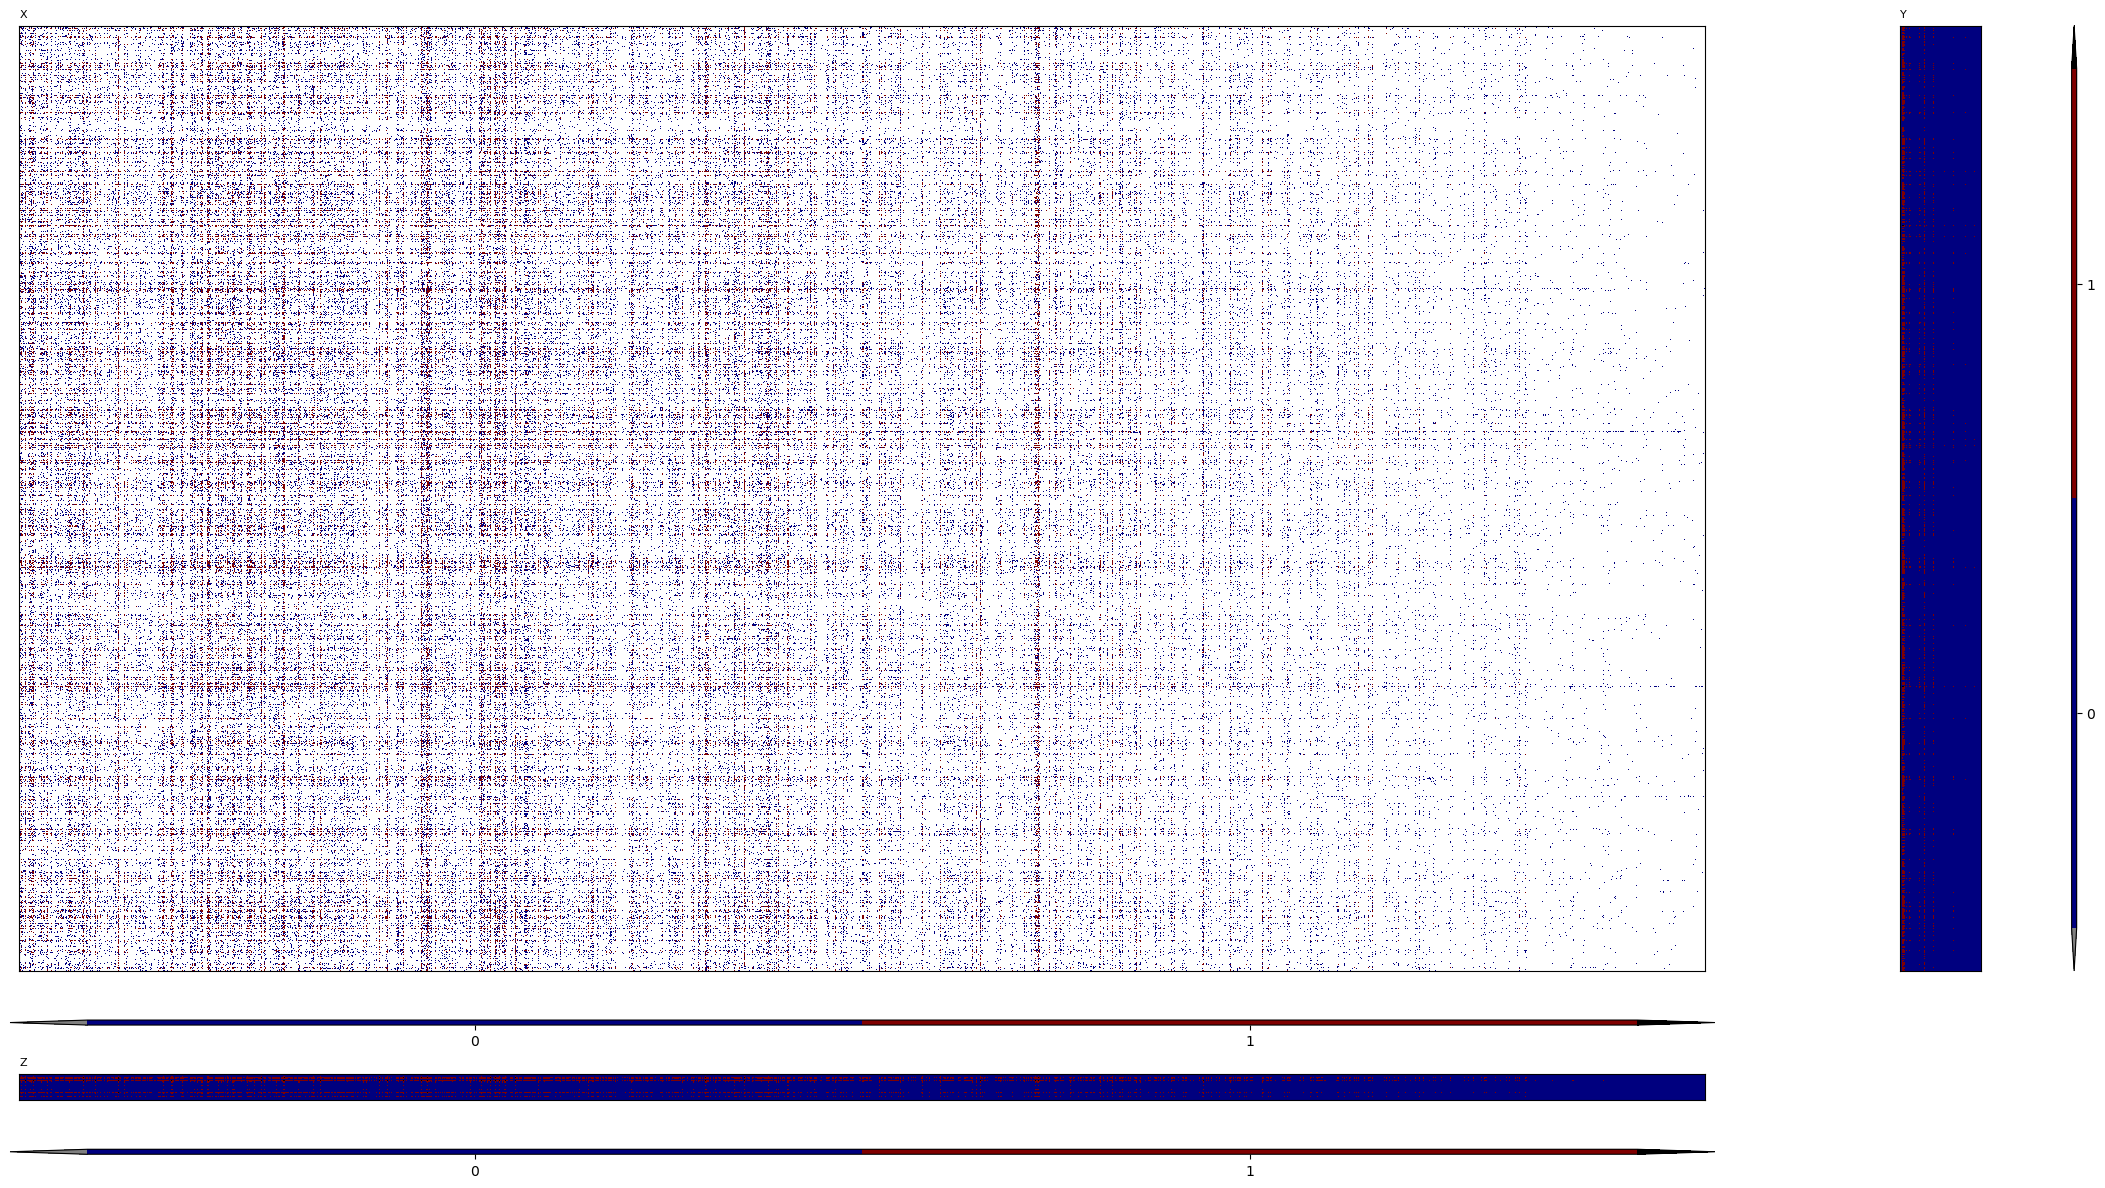

In [23]:
settings = [(X_train, [0, 0], 'X_train'), 
            (Y, [0, 1], 'Y'), 
            (Z, [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

settings = [(X_recover, [0, 0], 'X'), 
            (Q, [0, 1], 'Y'), 
            (R, [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

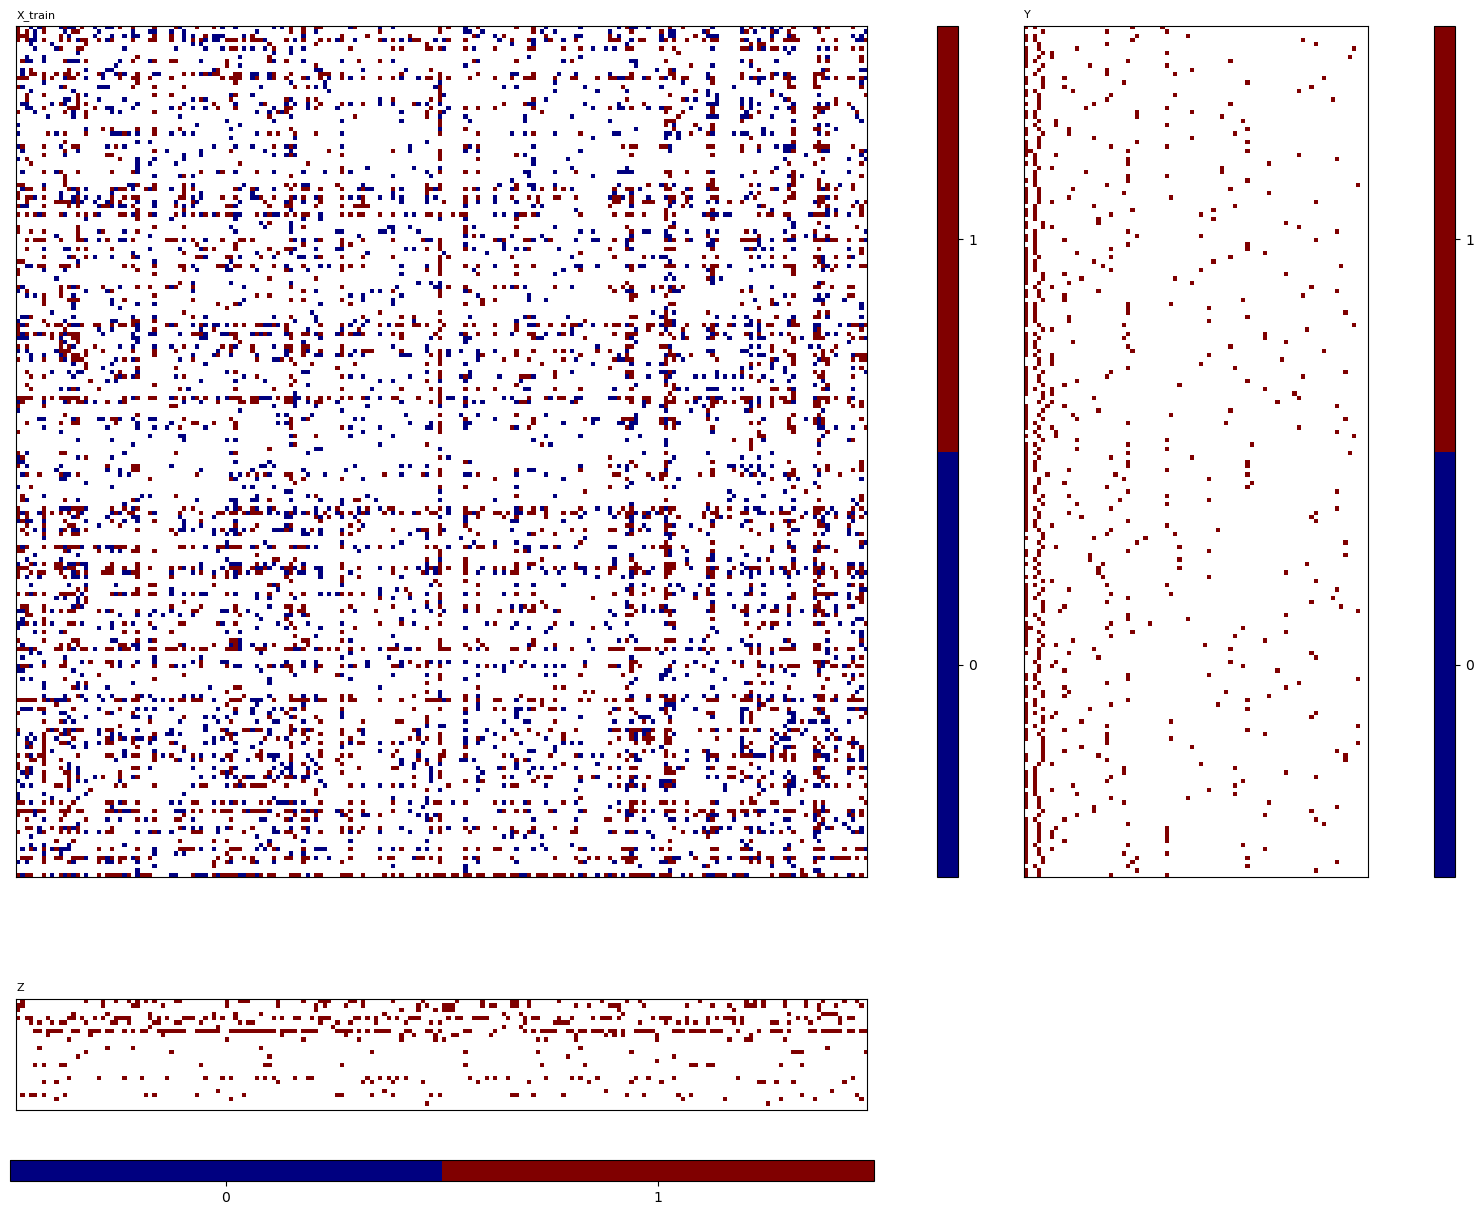

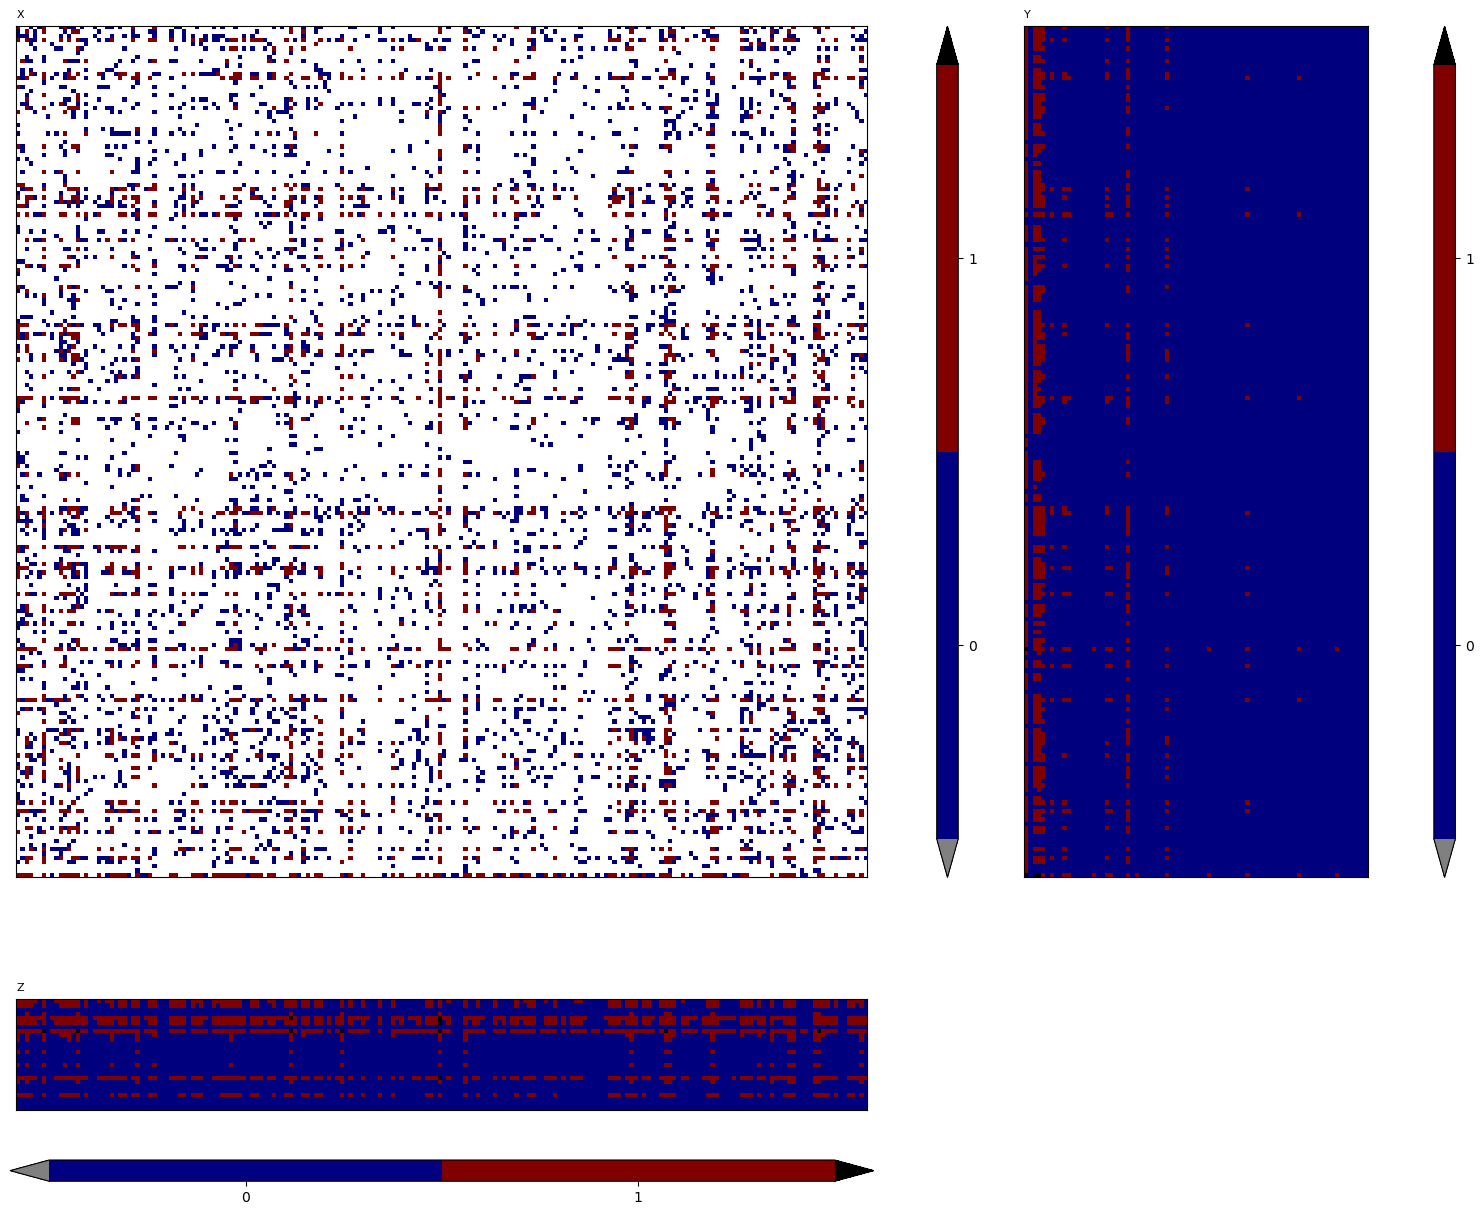

In [24]:
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (Y[:rng[0], :], [0, 1], 'Y'), 
            (Z[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

settings = [(X_recover[:rng[0], :rng[1]], [0, 0], 'X'), 
            (Q[:rng[0], :], [0, 1], 'Y'), 
            (R[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

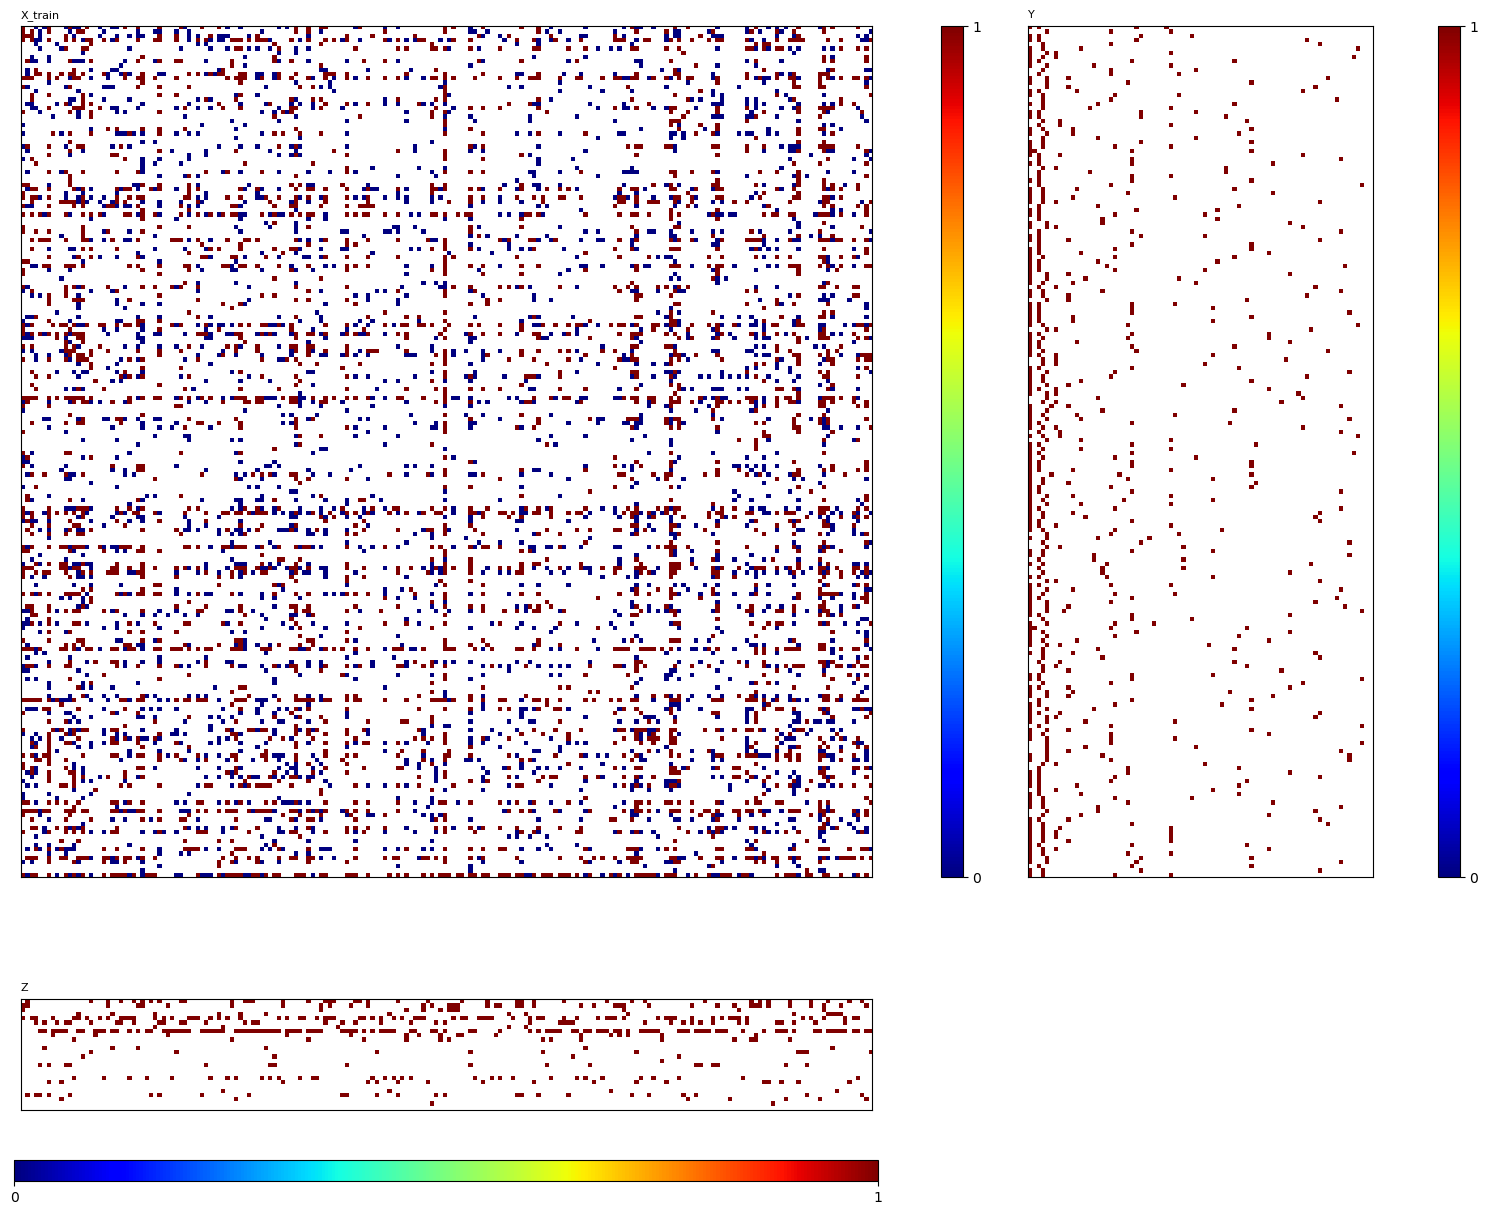

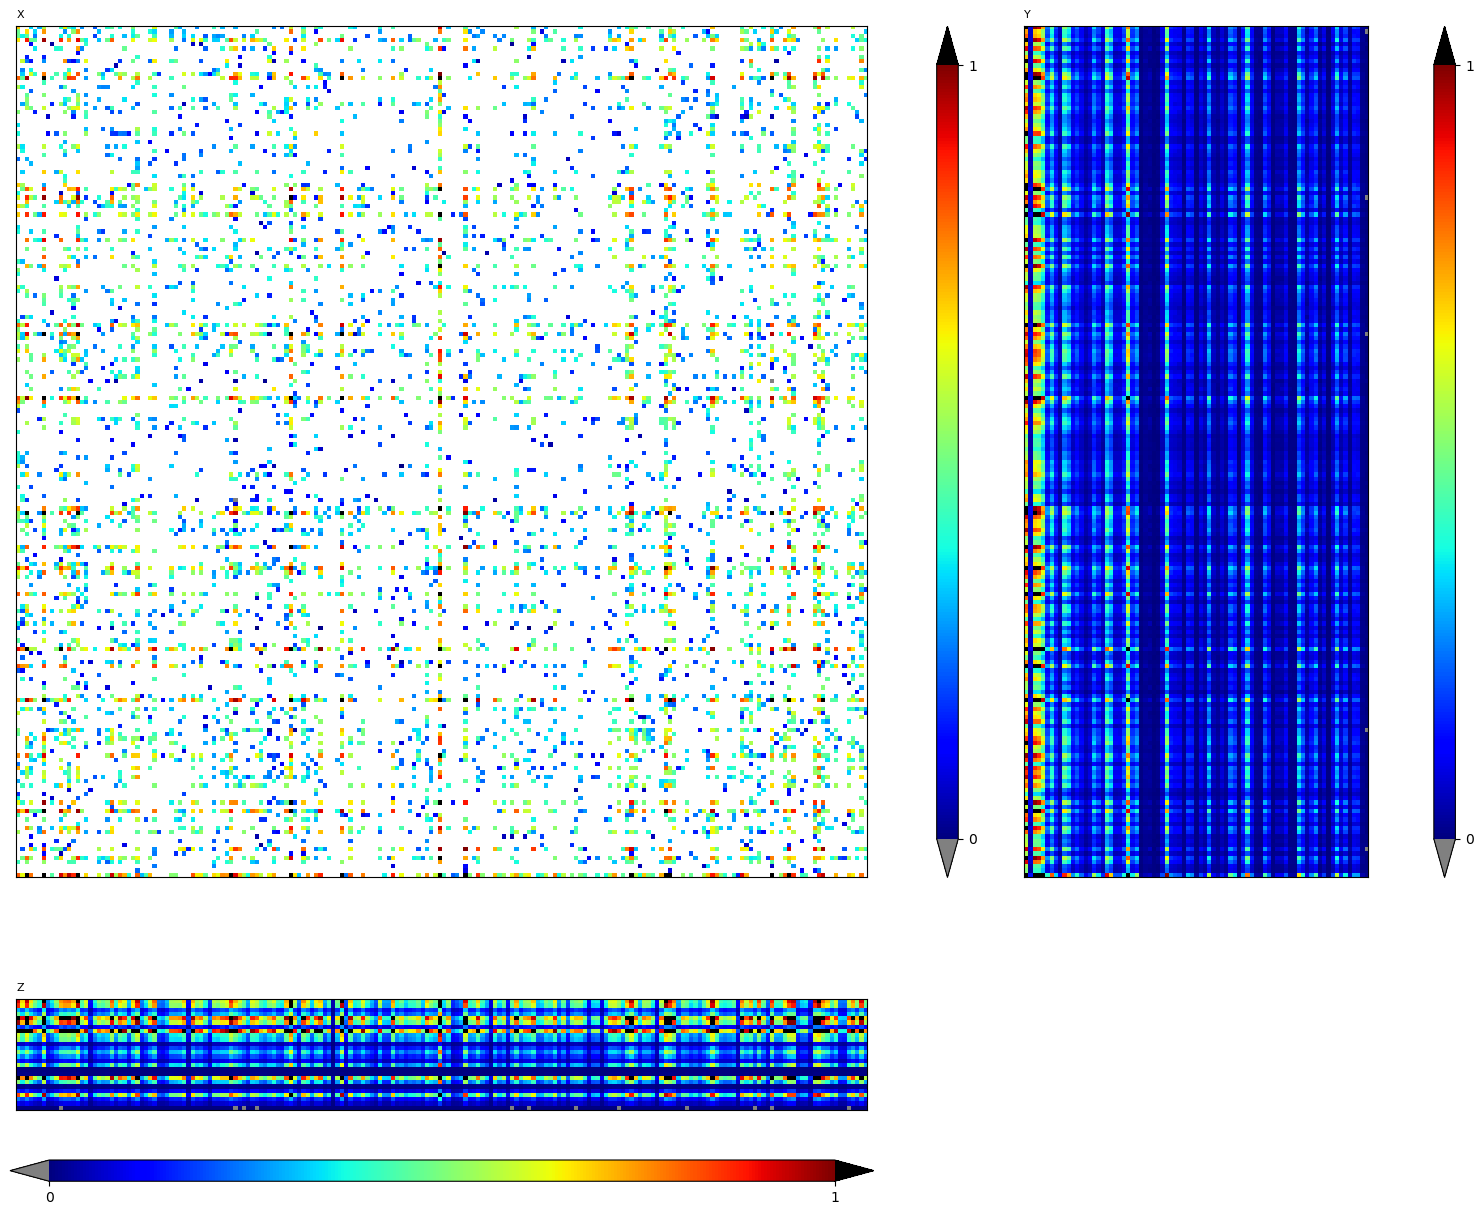

In [25]:
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (Y[:rng[0], :], [0, 1], 'Y'), 
            (Z[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=False, keep_nan=True)

settings = [(X_recover[:rng[0], :rng[1]], [0, 0], 'X'), 
            (Q[:rng[0], :], [0, 1], 'Y'), 
            (R[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=False, keep_nan=True)

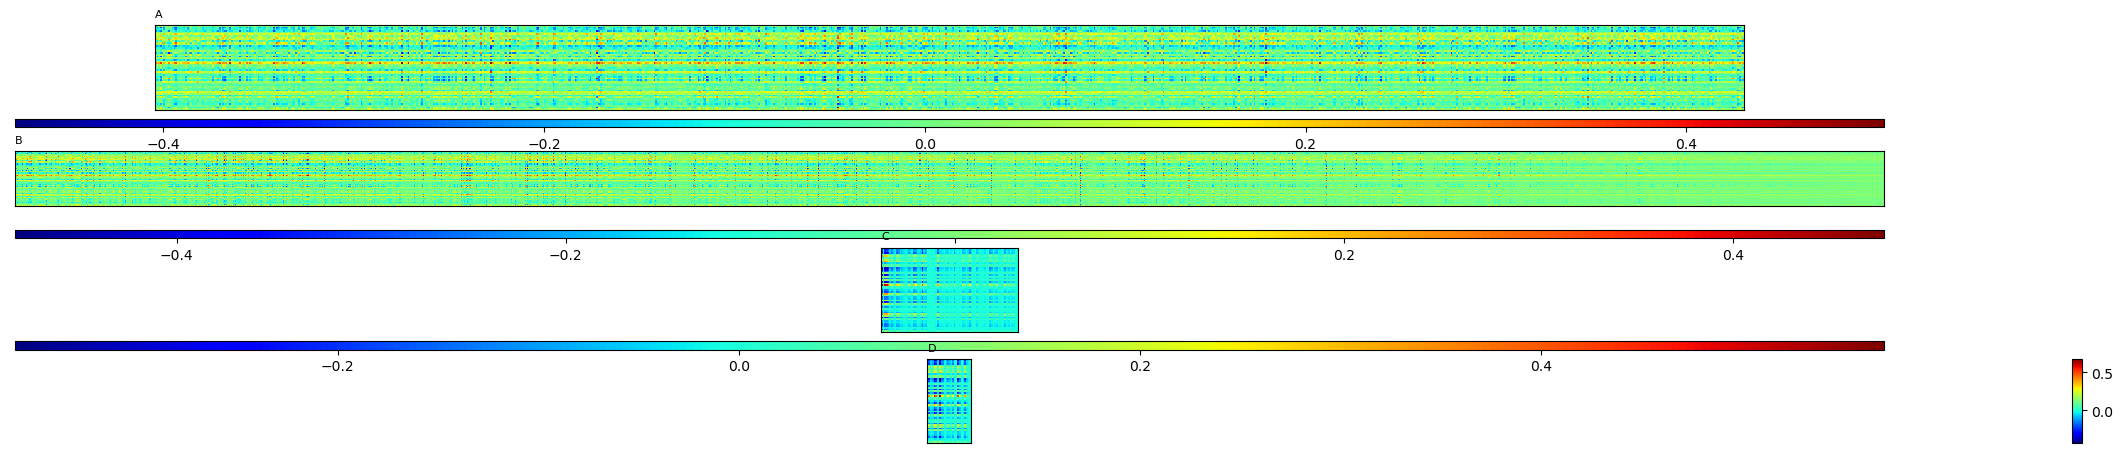

In [27]:
settings = [(A.T, [0, 0], 'A'), 
            (B.T, [1, 0], 'B'), 
            (C.T, [2, 0], 'C'), 
            (D.T, [3, 0], 'D')]
show_matrix(settings=settings, colorbar=True, clim=None, discrete=False, keep_nan=True)

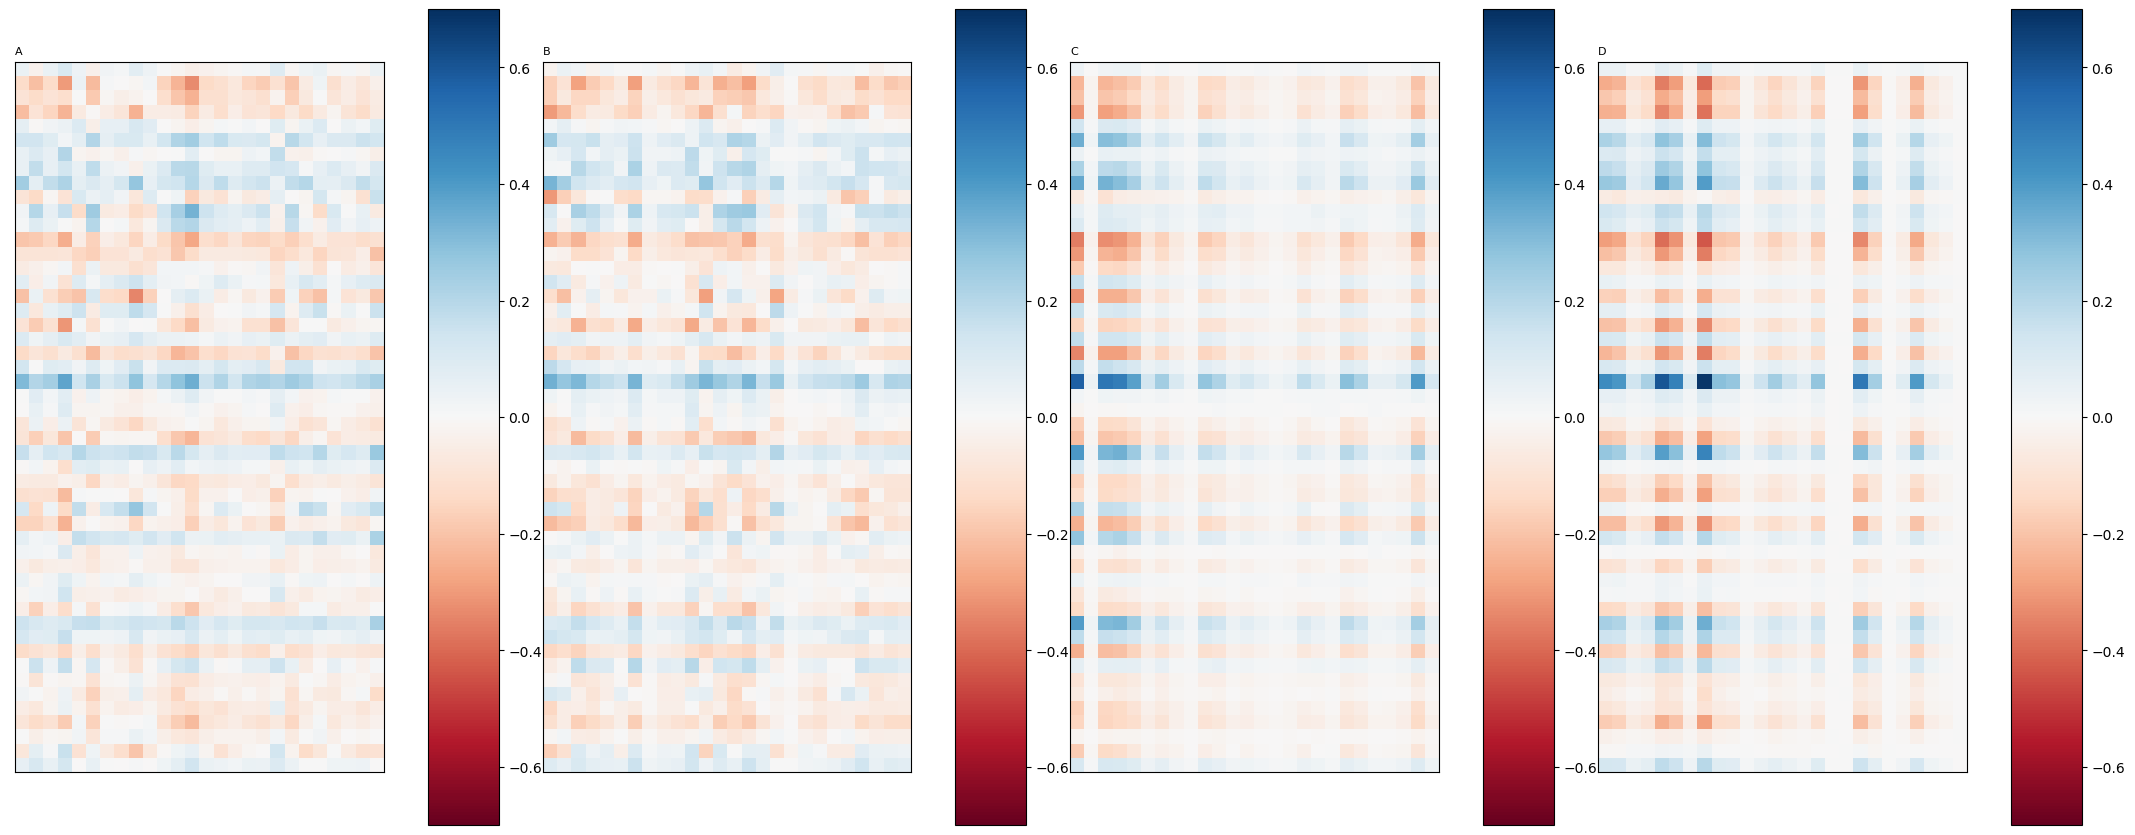

In [33]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.7, 0.7], cmap='RdBu', discrete=False, keep_nan=True)

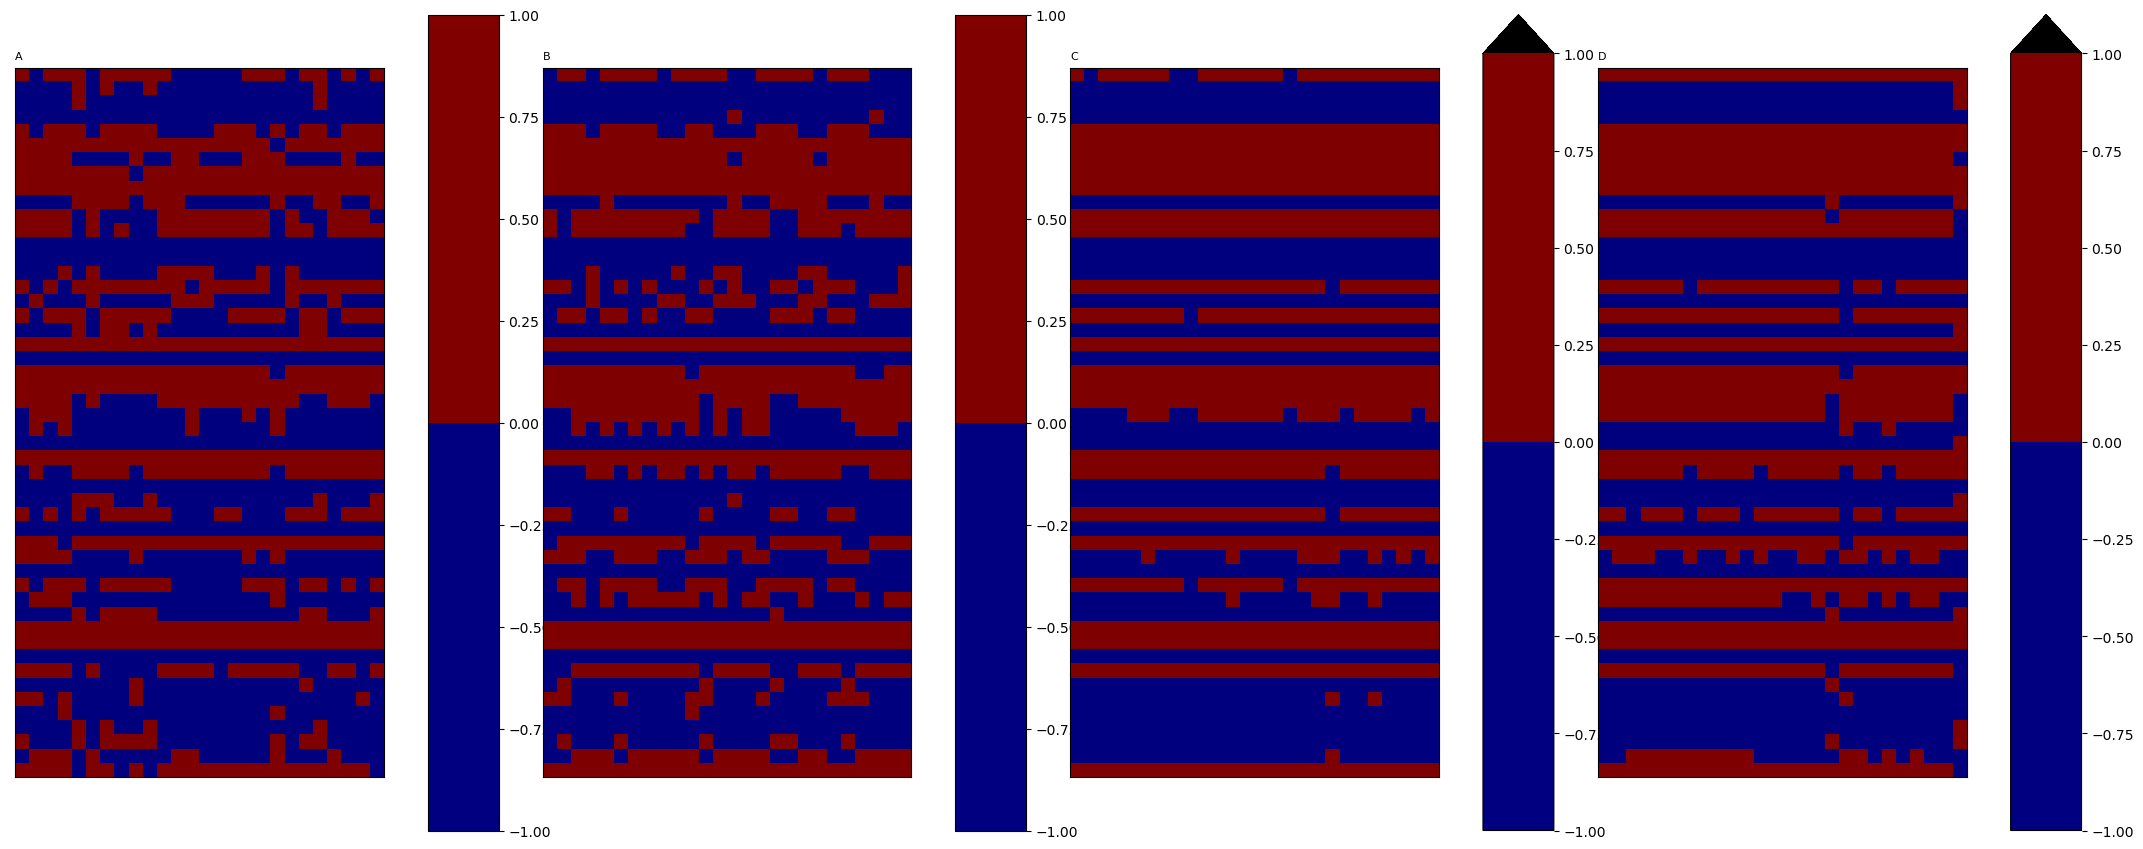

In [32]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.5, 0.5], discrete=True, center=True, keep_nan=True)

In [ ]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.5, 0.5], discrete=True, center=True, keep_nan=True)